# Web Data Scraping

[Spring 2021 ITSS Mini-Course](https://www.colorado.edu/cartss/programs/interdisciplinary-training-social-sciences-itss/mini-course-web-data-scraping) — ARSC 5040  
[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT)

## Class outline

* **Week 1**: Introduction to Jupyter, browser console, structured data, ethical considerations
* **Week 2**: Scraping HTML with `requests` and `BeautifulSoup`
* **Week 3**: Scraping web data with Selenium
* **Week 4**: Scraping an API with `requests` and `json`, Wikipedia and Reddit
* **Week 5**: Scraping data from Twitter

## Acknowledgements

Thank you also to Professor [Terra KcKinnish](https://www.colorado.edu/economics/people/faculty/terra-mckinnish) for coordinating the ITSS seminars.

## Class 5 goals

* Sharing accomplishments and challenges with last week's material
* Using the `twitter` wrapper library to handle authentication
* Retrieving and parsing a single tweet
* Rehydrating a list of tweet IDs
* Pulling a user's timeline
* Pulling a user's friend and follower lists
* Using the search endpoint of the API
* Listen to the streaming API
* Detecting bot accounts using IU's Bot-o-Meter

Start with our usual suspect packages.

In [1]:
# Lets Jupyter Notebook display images in-line
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

# Import our helper libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import json
import requests
from bs4 import BeautifulSoup
import time
from urllib.parse import quote, unquote

We're going to use a library called VADER to help with sentiment analysis of tweets. We need to do some setup first! You should only need to do this step once.

In [3]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/briankeegan/nltk_data...


True

Now try to import.

In [4]:
# Import the VADER sentiment analyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Instantiate the model
sia = SentimentIntensityAnalyzer()

## Installing a Twitter API wrapper

As was the case with Reddit, we will take advantage of a wrapper library to handle the heavy lifting of authenticating, making specific requests, handling rate-limiting, *etc*. There are no shortage of Python wrappers for the Twitter API, but the most popular are:

* [twitter](https://github.com/python-twitter-tools/twitter)
* [python-twitter](https://python-twitter.readthedocs.io/en/latest/)
* [Tweepy](http://docs.tweepy.org/en/latest/)
* [Twython](https://twython.readthedocs.io/en/latest/)

There are other wrapper libraries linked from the [Twitter developer utilities documentation](https://developer.twitter.com/en/docs/twitter-api/tools-and-libraries).

I'm going to use `twitter` just because it is very lightweight and replicates the official Twitter API's design.

You will need to install this since it does not come with conda by default. At the Terminal:

`pip install twitter`

Once you've installed it, you can import the `twitter` wrapper library.

In [5]:
import twitter

## Authenticating
I don't want to share my Twitter credentials with the world, so I load from from my local machine. If you wanted to do this, it should take this format of:

```
{"consumer_key":"API key",
 "consumer_secret":"API secret key",
 "access_token_key":"Access token",
 "access_token_secret":"Access token secret"
}
```

In [22]:
# Load my key information from disk
with open('twitter_keys.json','r') as f:
    twitter_keys = json.load(f)

# Authenticate with the Twitter API using the twitter_keys dictionary
# The "tweet_mode='extended' allows us to see the full 280 characters in tweets
api = twitter.Twitter(auth=twitter.OAuth(twitter_keys['access_token_key'],
                                         twitter_keys['access_token_secret'],
                                         twitter_keys['consumer_key'],
                                         twitter_keys['consumer_secret']),
                     )

Alternatively, you can just enter your keys directly into the `Api` function.

In [4]:
api = twitter.Api(consumer_key = 'API key',
                  consumer_secret = 'API secret key',
                  access_token_key = 'Access token',
                  access_token_secret = 'Access token secret',
                  tweet_mode='extended')

Test that you can connect to the API. Retrieve *Daily Camera* journalist [@mitchellbyars](https://twitter.com/mitchellbyars)'s account information.

In [27]:
api.users.show(screen_name='mitchellbyars')

{'id': 117004374,
 'id_str': '117004374',
 'name': 'Mitchell Byars',
 'screen_name': 'mitchellbyars',
 'location': 'Boulder, CO via Kona, Hawaii',
 'profile_location': None,
 'description': 'Crime and breaking news/social media/web @dailycamera; CU grad; Hawaiian surviving in a landlocked state with the help of beer, golf and snuggies. #ScannerFTW',
 'url': 'https://t.co/6GP7akhHHX',
 'entities': {'url': {'urls': [{'url': 'https://t.co/6GP7akhHHX',
     'expanded_url': 'https://www.dailycamera.com/author/mitchell-byars/',
     'display_url': 'dailycamera.com/author/mitchel…',
     'indices': [0, 23]}]},
  'description': {'urls': []}},
 'protected': False,
 'followers_count': 20701,
 'friends_count': 15497,
 'listed_count': 465,
 'created_at': 'Wed Feb 24 07:00:45 +0000 2010',
 'favourites_count': 5051,
 'utc_offset': None,
 'time_zone': None,
 'geo_enabled': True,
 'verified': True,
 'statuses_count': 49716,
 'lang': None,
 'status': {'created_at': 'Thu Mar 25 00:47:17 +0000 2021',
  '

We can also retrieve his most recent tweets. Obnoxiously, you also need to add a parameter `tweet_mode='extended'` ([docs](https://developer.twitter.com/en/docs/twitter-api/tweets/timelines/migrate/standard-to-twitter-api-v2)) to get the full 280 characters of text.

In [28]:
api.statuses.user_timeline(screen_name='mitchellbyars',
                           count=5,
                           tweet_mode='extended')

[{'created_at': 'Thu Mar 25 00:47:17 +0000 2021',
  'id': 1374885563929518082,
  'id_str': '1374885563929518082',
  'full_text': '@djswearingen *Fiddles with wires* Dangit, it was only supposed to constantly repeat the part about me',
  'truncated': False,
  'display_text_range': [14, 102],
  'entities': {'hashtags': [],
   'symbols': [],
   'user_mentions': [{'screen_name': 'djswearingen',
     'name': 'Deborah Swearingen',
     'id': 2292152588,
     'id_str': '2292152588',
     'indices': [0, 13]}],
   'urls': []},
  'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
  'in_reply_to_status_id': 1374884503957557248,
  'in_reply_to_status_id_str': '1374884503957557248',
  'in_reply_to_user_id': 2292152588,
  'in_reply_to_user_id_str': '2292152588',
  'in_reply_to_screen_name': 'djswearingen',
  'user': {'id': 117004374,
   'id_str': '117004374',
   'name': 'Mitchell Byars',
   'screen_name': 'mitchellbyars',
   'location': 'Boulder, CO via

## Getting the payload of a single tweet

Wikipedia helpfully maintains a [List of most-retweeted tweets](https://en.wikipedia.org/wiki/List_of_most-retweeted_tweets). Go to one of the tweets and pull out the ID at the end of the URL.

In [13]:
tweet = api.statuses.show(_id='849813577770778624')

In [15]:
tweet

{'created_at': 'Thu Apr 06 02:38:40 +0000 2017',
 'id': 849813577770778624,
 'id_str': '849813577770778624',
 'text': 'HELP ME PLEASE. A MAN NEEDS HIS NUGGS https://t.co/4SrfHmEMo3',
 'truncated': False,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 849813572351737856,
    'id_str': '849813572351737856',
    'indices': [38, 61],
    'media_url': 'http://pbs.twimg.com/media/C8sk8QlUwAAR3qI.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/C8sk8QlUwAAR3qI.jpg',
    'url': 'https://t.co/4SrfHmEMo3',
    'display_url': 'pic.twitter.com/4SrfHmEMo3',
    'expanded_url': 'https://twitter.com/carterjwm/status/849813577770778624/photo/1',
    'type': 'photo',
    'sizes': {'small': {'w': 382, 'h': 680, 'resize': 'fit'},
     'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'medium': {'w': 675, 'h': 1200, 'resize': 'fit'},
     'large': {'w': 750, 'h': 1334, 'resize': 'fit'}}}]},
 'extended_entities': {'media': [{'id': 8498135

Access the attributes of this dictionary.

In [16]:
# When was the tweet created
tweet['created_at']

'Thu Apr 06 02:38:40 +0000 2017'

In [18]:
# Number of favorites (at the time of the API call)
tweet['favorite_count']

936778

In [19]:
# Number of retweets (at the time of the API call)
tweet['retweet_count']

3210087

In [29]:
# Text of the tweet
tweet['text']

'HELP ME PLEASE. A MAN NEEDS HIS NUGGS https://t.co/4SrfHmEMo3'

In [30]:
# Location (if it geo-located)
tweet['geo']

In [32]:
# List of hashtags present
tweet['entities']['hashtags']

[]

In [33]:
# Tweet ID
tweet['id']

849813577770778624

In [34]:
# A guess at the language of the tweet
tweet['lang']

'en'

These next two attributes return `User` and `Media` objects rather than simple strings, ints, *etc*. that have their own attributes and methods.

In [35]:
tweet['user']

{'id': 2568270758,
 'id_str': '2568270758',
 'name': 'Carter Wilkerson',
 'screen_name': 'carterjwm',
 'location': 'Reno, NV - San Diego, CA',
 'description': 'Wendy’s Nugget Kid, yes i did get the nuggets! 🇵🇷',
 'url': None,
 'entities': {'description': {'urls': []}},
 'protected': False,
 'followers_count': 81017,
 'friends_count': 383,
 'listed_count': 264,
 'created_at': 'Sun Jun 15 03:48:03 +0000 2014',
 'favourites_count': 32619,
 'utc_offset': None,
 'time_zone': None,
 'geo_enabled': True,
 'verified': True,
 'statuses_count': 2011,
 'lang': None,
 'contributors_enabled': False,
 'is_translator': False,
 'is_translation_enabled': False,
 'profile_background_color': 'C0DEED',
 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme1/bg.png',
 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme1/bg.png',
 'profile_background_tile': False,
 'profile_image_url': 'http://pbs.twimg.com/profile_images/1317928663719899136/_gmCJlz6_normal.j

We can access attributes of this `User` object.

In [36]:
# Screen name of the user
tweet['user']['screen_name']

'carterjwm'

In [37]:
# Displayed name of the user
tweet['user']['name']

'Carter Wilkerson'

In [38]:
# User biography
tweet['user']['description']

'Wendy’s Nugget Kid, yes i did get the nuggets! 🇵🇷'

In [39]:
# Account creation time
tweet['user']['created_at']

'Sun Jun 15 03:48:03 +0000 2014'

In [40]:
# Self-reported location
tweet['user']['location']

'Reno, NV - San Diego, CA'

In [41]:
# Number of tweets from the user
tweet['user']['statuses_count']

2011

In [42]:
# Number of followers
tweet['user']['followers_count']

81017

In [43]:
# Number of friends (accounts this account follows, followees, etc.)
tweet['user']['friends_count']

383

Similarly, the `Media` object inside this list contains information about the type and the URLs of the media inside this object. If there were multiple images in this tweet, there would be a `Media` item in the list for each of them.

In [46]:
tweet['entities']['media'][0]['media_url']

'http://pbs.twimg.com/media/C8sk8QlUwAAR3qI.jpg'

## Rehydrating a list of tweets

Twitter's Terms of Service do not allow datasets of statuses to be shared, but researchers are permitted to share the identifiers for tweets in their datasets. Researchers then need to "rehydrate" these statuses by requesting the full payloads from Twitter's API. A list of resources with links to tweet IDs used in research:

* [DocNow's Tweet ID Datasets](https://www.docnow.io/catalog/)
* [FollowTheHashtag's Free Twitter Datasets](http://followthehashtag.com/datasets/)
* [AcademicTorrents](http://academictorrents.com/browse.php?search=twitter)
* [FiveThirtyEight's Russian Troll Tweets](https://github.com/fivethirtyeight/russian-troll-tweets/)
* [Harvard Dataverse](https://dataverse.harvard.edu/dataverse/harvard?q=twitter&types=datasets&sort=score&order=desc&page=1)

This has some privacy benefits: Twitter's [compliance statement](https://developer.twitter.com/en/docs/twitter-api/enterprise/compliance-firehose-api/overview) describes that users should retain the option to delete tweets or their accounts and this rehydration arrangement—theoretically—prevents their tweet content from circulating without their consent. In practice, many of the largest Twitter corpora come from the streaming API (more on that later in this notebook) and Twitter has a "[compliance stream](https://developer.twitter.com/en/docs/tweets/compliance/api-reference/compliance-firehose)" that indicates that a user has deleted a tweet, protected their account, Twitter has suspended an account, Twitter has withheld the status, *etc*. and the tweet should be removed from your streaming dataset as well. The Sunlight Foundation and ProPublica maintain a list of deleted tweets from politicians called [Politiwoops](https://projects.propublica.org/politwoops/).

I am going to use a [list of tweets made by Senators in the 115th Congress](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/UIVHQR) collected by Justin Littman in 2017. Load the text file:

In [48]:
with open('senators-115.txt','r') as f:
    senators_tweet_ids = [tweet_id.strip() for tweet_id in f.readlines()]
    
"There are {0:,} tweets IDs in the file.".format(len(senators_tweet_ids))

'There are 519,210 tweets IDs in the file.'

Look at the first 10 statuses.

In [49]:
senators_tweet_ids[:10]

['942793432321462273',
 '942513647695351808',
 '942439827970183169',
 '942419102597107713',
 '942419087833092096',
 '942403862673215488',
 '942402966673395713',
 '942402245991260160',
 '942401802628104197',
 '942399780008923138']

Use the `statuses.lookup` API endpoint, which accepts a string containing up to 100 comma-separated tweet IDs. We will use the "`map=True`" parameter to keep track of any tweets that were not returned (which should be `None`s rather than `Status`es).

In [85]:
senators_10_tweets = api.statuses.lookup(_id=','.join(senators_tweet_ids[:50]),
                                         map=True,
                                         tweet_mode='extended'
                                        )

Inspect.

In [87]:
list(senators_10_tweets['id'].values())[0]

{'created_at': 'Tue Dec 12 16:51:18 +0000 2017',
 'id': 940625117176041472,
 'id_str': '940625117176041472',
 'full_text': 'Today, let’s get everyone to vote.\n\nThank you, @JoeBiden https://t.co/2BdAWBZin9',
 'truncated': False,
 'display_text_range': [0, 56],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'JoeBiden',
    'name': 'Joe Biden',
    'id': 939091,
    'id_str': '939091',
    'indices': [47, 56]}],
  'urls': [{'url': 'https://t.co/2BdAWBZin9',
    'expanded_url': 'https://twitter.com/joebiden/status/940326781688664074',
    'display_url': 'twitter.com/joebiden/statu…',
    'indices': [57, 80]}]},
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 239548513,
  'id_str': '239548513',
  'name': 'Doug Jones',
  'scree

Now for a bit of accounting on rate limits. According to the API documentation for [get statuses/lookup](https://developer.twitter.com/en/docs/tweets/post-and-engage/api-reference/get-statuses-lookup), you can ask for up to 100 tweets per request and you can make 900 requests per 15-minutes. This means you can theoretically rehydrate 90,000 tweets per 15 minutes, or 360,000 tweets per hour. So it would take approximately 90 minutes to rehydrate all 500,000 of these senators' tweets.

In [69]:
api.application.rate_limit_status()

{'rate_limit_context': {'access_token': '16629994-Ok5mHtu0XIXxkVa6cDPkdXIemxStOwvgPnEBhrbQ6'},
 'resources': {'lists': {'/lists/list': {'limit': 15,
    'remaining': 15,
    'reset': 1616641069},
   '/lists/memberships': {'limit': 75, 'remaining': 75, 'reset': 1616641069},
   '/lists/subscribers/show': {'limit': 15,
    'remaining': 15,
    'reset': 1616641069},
   '/lists/members': {'limit': 900, 'remaining': 900, 'reset': 1616641069},
   '/lists/subscriptions': {'limit': 15, 'remaining': 15, 'reset': 1616641069},
   '/lists/show': {'limit': 75, 'remaining': 75, 'reset': 1616641069},
   '/lists/ownerships': {'limit': 15, 'remaining': 15, 'reset': 1616641069},
   '/lists/subscribers': {'limit': 180, 'remaining': 180, 'reset': 1616641069},
   '/lists/members/show': {'limit': 15, 'remaining': 15, 'reset': 1616641069},
   '/lists/statuses': {'limit': 900, 'remaining': 900, 'reset': 1616641069}},
  'application': {'/application/rate_limit_status': {'limit': 180,
    'remaining': 179,
    '

Access the field with the rate limit status for looking up statuses.

In [78]:
api.application.rate_limit_status()['resources']['statuses']['/statuses/lookup']

{'limit': 900, 'remaining': 900, 'reset': 1616641637}

Parse out when the the API limit will reset.

In [80]:
# Access the reset field
reset_datetime = api.application.rate_limit_status()['resources']['statuses']['/statuses/lookup']['reset']

# Convert from UNIX time to something interpretable
print(datetime.fromtimestamp(reset_datetime))

2021-03-24 21:09:16


There should be 10 `Status` objects returned by the API.

In [82]:
len(senators_10_tweets['id'])

10

Write a loop to go through the ten tweets and print out information.

In [83]:
for status in senators_10_tweets['id'].values():
    screen_name = status['user']['screen_name']
    created = pd.to_datetime(status['created_at'])
    text = status['full_text']
    retweets = status['retweet_count']
    formatted_str = '{0} on {1} said {2}, which received {3} retweets.\n'
    print(formatted_str.format(screen_name,created,text,retweets))

DougJones on 2017-12-17 14:23:11+00:00 said "Everyone needs to hit the political reset button and examine issues in a way that best helps the people of Alabama.", which received 262 retweets.

DougJones on 2017-12-17 21:55:39+00:00 said “I think there’s an opportunity at every turn,” he said on “Fox News Sunday” before adding such cooperation is a “two-way street.” https://t.co/b8CVmgvQG5, which received 213 retweets.

DougJones on 2017-12-17 15:39:54+00:00 said RT @CBSSunday: "When you're on the right side of history you can accomplish a lot of things, " says Alabama senator-elect @GDouglasJones 
#…, which received 268 retweets.

DougJones on 2017-12-17 15:39:58+00:00 said RT @CBSSunday: .@BojorquezCBS: Do you think you would have won had @washingtonpost not broken the story about sexual misconduct allegations…, which received 90 retweets.

DougJones on 2017-12-17 14:35:50+00:00 said Doug on Senate #tax bill: "I have real concerns about a tax plan that would add $1 trillion to the nat

Alternatively, extract the relevant fields, save these as a list of dictionaries, and convert the list of dictionaries to a DataFrame. Note that when an account retweets another account, a second `Status` object is embedded under the "`.retweeted_status`" attribute that contains the parent tweet's information. In these cases, the "`.created_at`" from the Senator's account is when s/he retweeted the status and the "`.created_at`" for the "`.retweeted_status`" is when the parent tweet was first posted.

In [104]:
list(senators_10_tweets['id'].values())[1]

{'created_at': 'Tue Dec 12 15:36:12 +0000 2017',
 'id': 940606216786665477,
 'id_str': '940606216786665477',
 'full_text': 'RT @aldotcom: Just in case you were wondering... \n\n#alpolitics #alsen https://t.co/CcYh4mVhtu',
 'truncated': False,
 'display_text_range': [0, 93],
 'entities': {'hashtags': [{'text': 'alpolitics', 'indices': [51, 62]},
   {'text': 'alsen', 'indices': [63, 69]}],
  'symbols': [],
  'user_mentions': [{'screen_name': 'aldotcom',
    'name': 'AL.com',
    'id': 14528874,
    'id_str': '14528874',
    'indices': [3, 12]}],
  'urls': [],
  'media': [{'id': 940604753603465216,
    'id_str': '940604753603465216',
    'indices': [70, 93],
    'media_url': 'http://pbs.twimg.com/media/DQ2zCjSUEAAh5k5.png',
    'media_url_https': 'https://pbs.twimg.com/media/DQ2zCjSUEAAh5k5.png',
    'url': 'https://t.co/CcYh4mVhtu',
    'display_url': 'pic.twitter.com/CcYh4mVhtu',
    'expanded_url': 'https://twitter.com/aldotcom/status/940604756128616448/photo/1',
    'type': 'photo',
 

In [106]:
# Make an empty list to store the data after we process it below
statuses_list = []

# Loop through each of the status objects
for status in senators_10_tweets['id'].values():
    
    # Check to make sure the status is not empty/None 
    if status != None:
        
        # Create an empty dictionary to store relevant fields
        payload = {}
        payload['id'] = status['id_str']
        payload['screen_name'] = status['user']['screen_name']
        payload['created'] = pd.to_datetime(status['created_at'])
        payload['retweets'] = status['retweet_count']
        payload['favorites'] = status['favorite_count']

        # If an account retweets another account, we should store that information
        if 'retweeted_status' in status:
            payload['text'] = status['retweeted_status']['full_text']
            payload['retweeted'] = True
            payload['retweeted_screen_name'] = status['retweeted_status']['user']['screen_name']
            payload['retweeted_created'] = status['retweeted_status']['created_at']
            
        # If there is no retweeted_status then it's not a retweet
        else:
            payload['text'] = status['full_text']
            payload['retweeted'] = False
            payload['retweeted_screen_name'] = False
            payload['retweeted_created'] = False

        # Store the payload dictionary in our list
        statuses_list.append(payload)
        
# Conver to a DataFrame
df = pd.DataFrame(statuses_list)

# Inspect
df.head()

,id,screen_name,created,retweets,favorites,text,retweeted,retweeted_screen_name,retweeted_created
0,940625117176041472,DougJones,2017-12-12 16:51:18+00:00,1187,5154,"Today, let’s get everyone to vote.\n\nThank yo...",False,False,False
1,940606216786665477,DougJones,2017-12-12 15:36:12+00:00,504,0,Just in case you were wondering... \n\n#alpoli...,True,aldotcom,Tue Dec 12 15:30:24 +0000 2017
2,941381292205268992,DougJones,2017-12-14 18:56:04+00:00,146,915,It was great to join Don Dailey on @APTV to ta...,False,False,False
3,940732903738298370,DougJones,2017-12-12 23:59:36+00:00,1661,3928,Polls close in ONE HOUR. Make sure to get to y...,False,False,False
4,942399780008923138,DougJones,2017-12-17 14:23:11+00:00,262,1804,"""Everyone needs to hit the political reset but...",False,False,False


## Pulling a user's timeline

In general, if you want to retrieve the tweets from a user's timeline, we can use Twitter's API to get the 3,200 most recent tweets from the [get statuses/user_timeline](https://developer.twitter.com/en/docs/tweets/timelines/api-reference/get-statuses-user_timeline.html) API endpoint. This will include retweets of other statuses. We can retrieve up to 200 tweets per request and can make 900 requests per 15-minute window, so we can get 18,000 tweets per window or 72,000 tweets per hour. This means we could theoretically get up to 22 users' most recent 3,200 tweets per hour.

Alexandria Ocasio-Cortez has written 6,975 tweets on her personal account, "[AOC](https://twitter.com/aoc)". She also has an official account "[RepAOC](https://twitter.com/repaoc)", but this only has 14 tweets. Let's get her 3,200 most-recent tweets from the API. Disappointingly, `python-twitter` does not handle the "pagination" for us so we can only ask for 200 tweets at a time and have to update when to ask for the next tweets.

In [107]:
aoc_tweets = api.statuses.user_timeline(screen_name='aoc',
                                        count=200,
                                        tweet_mode='extended')

In [111]:
print("{0:,} tweets were returned.".format(len(aoc_tweets)))

200 tweets were returned.


The first tweet returned is the most recent tweet.

In [112]:
aoc_tweets[0]['created_at']

'Wed Mar 24 15:44:14 +0000 2021'

The last tweet returned (the 200th).

In [113]:
aoc_tweets[-1]['created_at']

'Fri Feb 05 23:00:29 +0000 2021'

We really care about the final tweet's ID so we can make an API query that asks for the next 200 statuses before the last tweet returned.

In [114]:
aoc_tweets[-1]['id']

1357826457461006339

Now we make the next query.

In [116]:
aoc_tweets2 = api.statuses.user_timeline(screen_name='aoc',
                                         count=200,
                                         tweet_mode='extended',
                                         include_rts=True,
                                         max_id=aoc_tweets[-1]['id'])

Check the first tweet in here.

In [117]:
aoc_tweets2[0]['id']

1357826457461006339

Compare to the last tweet in the first set (`aoc_tweets`).

In [118]:
aoc_tweets[-1]['id']

1357826457461006339

Let's also check in on how much of our API rate limit we've used.

In [121]:
api.application.rate_limit_status()['resources']['statuses']['/statuses/user_timeline']

{'limit': 900, 'remaining': 898, 'reset': 1616644362}

Now we'll write a loop to get all 3,200 tweets.

In [124]:
# Start with the list of the 200 most-recent tweets
aoc_timeline_tweets = api.statuses.user_timeline(screen_name='aoc',
                                         count=200,
                                         tweet_mode='extended',
                                         include_rts=True)

# Initialize a counter so we don't go overboard with our requests
request_counter = 1

# While our request counter hasn't gone past 16, but try for more :)
while request_counter < 20:
    # Get the most oldest tweet id
    final_status_id = aoc_timeline_tweets[-1]['id']
    
    # Pass this tweet ID into the max_id parameter, minus 1 so we don't duplicate it
    aoc_timeline_tweets += api.statuses.user_timeline(screen_name='aoc',
                                                  count=200,
                                                  tweet_mode='extended',
                                                  include_rts=True,
                                                  max_id=final_status_id-1)
    
    # Increment our request_counter
    request_counter += 1

I just used a chunk of my API rate limit.

In [125]:
api.application.rate_limit_status()['resources']['statuses']['/statuses/user_timeline']

{'limit': 900, 'remaining': 881, 'reset': 1616645309}

Somehow a few more tweets snuck in there.

In [126]:
len(aoc_timeline_tweets)

3245

We can also abstract this into a function we could use for anyone's timeline.

In [131]:
def get_all_user_timeline(screen_name,count=200,include_rts=True,exclude_replies=False):
    
    # Start with the list of the 200 most-recent tweets
    timeline_tweets = api.statuses.user_timeline(screen_name = screen_name,
                                                 count = count,
                                                 tweet_mode = 'extended',
                                                 include_rts = include_rts,
                                                 exclude_replies = exclude_replies
                                                )

    # Initialize a counter so we don't go overboard with our requests
    request_counter = 1

    # While our request counter hasn't gone past 16, but try for 20
    while request_counter < 20:
        # Get the most oldest tweet id
        final_status_id = timeline_tweets[-1]['id']

        # Pass this tweet ID into the max_id parameter, minus 1 so we don't duplicate it
        timeline_tweets += api.statuses.user_timeline(screen_name = screen_name,
                                                      count = count,
                                                      tweet_mode = 'extended',
                                                      include_rts = include_rts,
                                                      exclude_replies = exclude_replies,
                                                      max_id = final_status_id-1)

        # Increment our request_counter
        request_counter += 1
        
    return timeline_tweets

Test this on [@joebiden](https://twitter.com/joebiden).

In [132]:
biden_tweets = get_all_user_timeline('joebiden')
len(biden_tweets)

3235

In [133]:
api.statuses.show(_id=1374874540078080003)

{'created_at': 'Thu Mar 25 00:03:28 +0000 2021',
 'id': 1374874540078080003,
 'id_str': '1374874540078080003',
 'text': 'Follow @djswearingen for more out of #Boulder https://t.co/7XUEDFKY5b',
 'truncated': False,
 'entities': {'hashtags': [{'text': 'Boulder', 'indices': [37, 45]}],
  'symbols': [],
  'user_mentions': [{'screen_name': 'djswearingen',
    'name': 'Deborah Swearingen',
    'id': 2292152588,
    'id_str': '2292152588',
    'indices': [7, 20]}],
  'urls': [{'url': 'https://t.co/7XUEDFKY5b',
    'expanded_url': 'https://twitter.com/djswearingen/status/1374873820650106887',
    'display_url': 'twitter.com/djswearingen/s…',
    'indices': [46, 69]}]},
 'source': '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 117004374,
  'id_str': '117004374',
  'name': 'Mit

I've added a lot more sugar into our loop to grab information about replies, user mentions, and hashtags.

In [141]:
# Make an empty list to store the data after we process it below
statuses_list = []

# Loop through each of the status objects
for status in biden_tweets:
    
    # Check to make sure the status is not empty/None 
    if status != None:
        
        # Create an empty dictionary to store relevant fields
        payload = {}
        payload['id'] = status['id_str']
        payload['screen_name'] = status['user']['screen_name']
        payload['created'] = pd.to_datetime(status['created_at'])
        payload['retweets'] = status['retweet_count']
        payload['favorites'] = status['favorite_count']
        payload['reply_screen_name'] = status['in_reply_to_screen_name']
        payload['reply_id'] = status['in_reply_to_status_id']
        payload['source'] = BeautifulSoup(status['source']).text

        if len(status['entities']['user_mentions']) > 0:
            payload['user_mentions'] = '; '.join([m['screen_name'] for m in status['entities']['user_mentions']])
        else:
            payload['user_mentions'] = None
            
        if len(status['entities']['hashtags']) > 0:
            payload['hashtags'] = '; '.join([h['text'] for h in status['entities']['hashtags']])
        else:
            payload['hashtags'] = None
        
        # If an account retweets another account, we should store that information
        if 'retweeted_status' in status:
            payload['text'] = status['retweeted_status']['full_text']
            payload['retweeted'] = True
            payload['retweeted_screen_name'] = status['retweeted_status']['user']['screen_name']
            payload['retweeted_created'] = status['retweeted_status']['created_at']
            payload['retweeted_source'] = BeautifulSoup(status['retweeted_status']['source']).text
            if len(status['retweeted_status']['entities']['hashtags']) > 0:
                payload['hashtags'] = '; '.join([h['text'] for h in status['retweeted_status']['entities']['hashtags']])
            else:
                payload['hashtags'] = None
        # If there is no retweeted_status then it's not a retweet
        else:
            payload['text'] = status['full_text']
            payload['retweeted'] = False
            payload['retweeted_screen_name'] = False
            payload['retweeted_created'] = False

        # Store the payload dictionary in our list
        statuses_list.append(payload)
        
# Conver to a DataFrame
df = pd.DataFrame(statuses_list)

# Inspect
df.head()

,id,screen_name,created,retweets,favorites,reply_screen_name,reply_id,source,user_mentions,hashtags,text,retweeted,retweeted_screen_name,retweeted_created,retweeted_source
0,1374761947913146374,JoeBiden,2021-03-24 16:36:04+00:00,1465,0,None,NaN,Twitter for iPhone,WHCOVIDResponse,None,"In total, 84 million people -- about 1 in 3 ad...",True,WHCOVIDResponse,Wed Mar 24 15:00:50 +0000 2021,Twitter Web App
1,1374524524931207168,JoeBiden,2021-03-24 00:52:38+00:00,2860,0,None,NaN,Twitter for iPhone,WhiteHouse,None,President Biden believes every single American...,True,WhiteHouse,Tue Mar 23 22:22:08 +0000 2021,The White House
2,1374414080694358016,JoeBiden,2021-03-23 17:33:46+00:00,5073,0,None,NaN,Twitter for iPhone,POTUS,None,Jill and I are devastated for the lives that h...,True,POTUS,Tue Mar 23 17:32:02 +0000 2021,The White House
3,1374105995023159297,JoeBiden,2021-03-22 21:09:33+00:00,3990,0,None,NaN,Twitter for iPhone,WhiteHouse,None,Big news: The Biden-Harris Administration set ...,True,WhiteHouse,Mon Mar 22 20:30:00 +0000 2021,The White House
4,1374059403108827137,JoeBiden,2021-03-22 18:04:25+00:00,7739,0,None,NaN,Twitter for iPhone,POTUS,None,"Under the American Rescue Plan, the typical fa...",True,POTUS,Mon Mar 22 14:30:01 +0000 2021,The White House


Convert the "created" column into a proper `datetime` object and extract the dates as another column.

In [142]:
df['timestamp'] = pd.to_datetime(df['created'])
df['date'] = df['timestamp'].apply(lambda x:x.date())
df['weekday'] = df['timestamp'].apply(lambda x:x.weekday)
df['hour'] = df['timestamp'].apply(lambda x:x.hour)

Make a plot of the number of tweets by date.

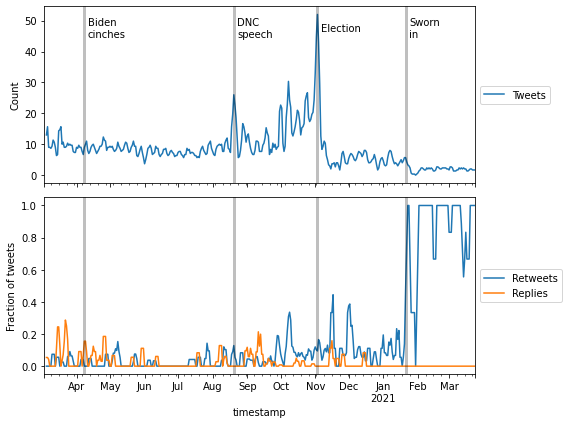

In [152]:
# Group by date and aggregate by number of tweets on that date
_s = df.groupby(pd.Grouper(key='timestamp',freq='1D')).agg({'id':len,'retweeted':'sum','reply_id':lambda x:sum(x.notnull())})

# Reindex the data to be continuous over the range, fill in missing dates as 0s
_s.columns = ['Tweets','Retweets','Replies']
_s_frac = _s[['Retweets','Replies']].div(_s['Tweets'],axis=0).fillna(0)

# Make the plot
f,axs = plt.subplots(2,1,figsize=(8,6),sharex=True)
_s['Tweets'].rolling(3).mean().plot(ax=axs[0])
_s_frac.rolling(3).mean().plot(ax=axs[1],legend=False)

axs[0].legend(loc='center left',bbox_to_anchor=(1,.5))
axs[1].legend(loc='center left',bbox_to_anchor=(1,.5))
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Fraction of tweets')

# Annotate the plot with lines corresponding to major events
for ax in axs:
    ax.axvline(pd.Timestamp('2020-04-08'),lw=3,c='k',alpha=.25) # Biden cinches
    ax.axvline(pd.Timestamp('2020-08-20'),lw=3,c='k',alpha=.25) # DNC speech
    ax.axvline(pd.Timestamp('2020-11-03'),lw=3,c='k',alpha=.25) # Election day
    ax.axvline(pd.Timestamp('2021-01-21'),lw=3,c='k',alpha=.25) # Swearing in
    
axs[0].text(x=pd.Timestamp('2020-04-08')+pd.Timedelta(3,'d'),y=47.5,s='Biden\ncinches',va='center')
axs[0].text(x=pd.Timestamp('2020-08-20')+pd.Timedelta(3,'d'),y=47.5,s='DNC\nspeech',va='center')
axs[0].text(x=pd.Timestamp('2020-11-03')+pd.Timedelta(3,'d'),y=47.5,s='Election',va='center')
axs[0].text(x=pd.Timestamp('2021-01-21')+pd.Timedelta(3,'d'),y=47.5,s='Sworn\nin',va='center')

f.tight_layout()
# f.savefig('aoc_activity.png',dpi=300,bbox_inches='tight')

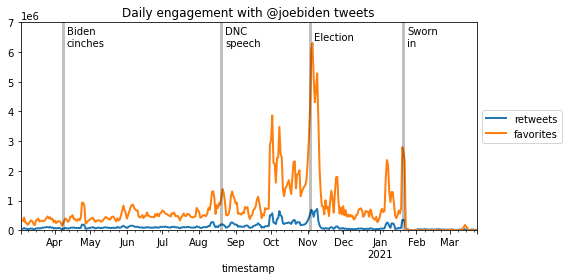

In [165]:
# Group by the date and aggregate by the sum of retweets and favorites for all tweets on that date
_s = df.groupby(pd.Grouper(key='timestamp',freq='1D')).agg({'retweets':'sum','favorites':'sum'})

# Make the plot
f,ax = plt.subplots(1,1,figsize=(8,4))
ax = _s.rolling(3).mean().plot(legend=False,lw=2,ax=ax)
ax.set_ylim((0,7000000))
ax.legend(loc='center left',bbox_to_anchor=(1,.5))
ax.set_title('Daily engagement with @joebiden tweets')

# Annotate the plot with lines corresponding to major events
ax.axvline(pd.Timestamp('2020-04-08'),lw=3,c='k',alpha=.25) # Biden cinches
ax.axvline(pd.Timestamp('2020-08-20'),lw=3,c='k',alpha=.25) # DNC speech
ax.axvline(pd.Timestamp('2020-11-03'),lw=3,c='k',alpha=.25) # Election day
ax.axvline(pd.Timestamp('2021-01-21'),lw=3,c='k',alpha=.25) # Swearing in
    
_y = 6.5e6
ax.text(x=pd.Timestamp('2020-04-08')+pd.Timedelta(3,'d'),y=_y,s='Biden\ncinches',va='center')
ax.text(x=pd.Timestamp('2020-08-20')+pd.Timedelta(3,'d'),y=_y,s='DNC\nspeech',va='center')
ax.text(x=pd.Timestamp('2020-11-03')+pd.Timedelta(3,'d'),y=_y,s='Election',va='center')
ax.text(x=pd.Timestamp('2021-01-21')+pd.Timedelta(3,'d'),y=_y,s='Sworn\nin',va='center')

f.tight_layout()
# f.savefig('joebiden_engagement.png',dpi=300,bbox_inches='tight')

We can also do a bit of sentiment analysis. You'll likely need to [install the NLTK data](https://www.nltk.org/data.html) for this to work. We are going to use the [VADER sentiment analysis tool](https://github.com/cjhutto/vaderSentiment) that was specifically trained for social media text: [see paper here](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf).

In [166]:
# Get sentiment scores for each tweet's text
df['sentiment'] = df['text'].apply(lambda x:sia.polarity_scores(x)['compound'])

Plot out the daily sentiment of tweets with major events annotated.

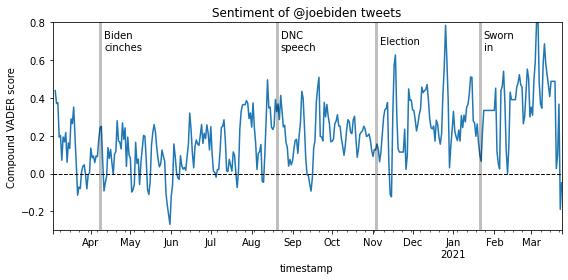

In [176]:
# Group by the date and aggregate by the average sentiment for all tweets on that date
_s = df.groupby(pd.Grouper(key='timestamp',freq='1D')).agg({'sentiment':'mean'})

# Make the plot with a 7-day rolling average
f,ax = plt.subplots(1,1,figsize=(8,4))
ax = _s.rolling(3).mean().fillna(method='ffill').plot(legend=False,ax=ax)
ax.set_ylim((-.3,.8))
ax.axhline(0,ls='--',c='k',lw=1)
ax.set_title('Sentiment of @joebiden tweets')
ax.set_ylabel('Compound VADER score')

# Annotate the plot with lines corresponding to major events
ax.axvline(pd.Timestamp('2020-04-08'),lw=3,c='k',alpha=.25) # Biden cinches
ax.axvline(pd.Timestamp('2020-08-20'),lw=3,c='k',alpha=.25) # DNC speech
ax.axvline(pd.Timestamp('2020-11-03'),lw=3,c='k',alpha=.25) # Election day
ax.axvline(pd.Timestamp('2021-01-21'),lw=3,c='k',alpha=.25) # Swearing in
    
_y = .7
ax.text(x=pd.Timestamp('2020-04-08')+pd.Timedelta(3,'d'),y=_y,s='Biden\ncinches',va='center')
ax.text(x=pd.Timestamp('2020-08-20')+pd.Timedelta(3,'d'),y=_y,s='DNC\nspeech',va='center')
ax.text(x=pd.Timestamp('2020-11-03')+pd.Timedelta(3,'d'),y=_y,s='Election',va='center')
ax.text(x=pd.Timestamp('2021-01-21')+pd.Timedelta(3,'d'),y=_y,s='Sworn\nin',va='center')

f.tight_layout()
# f.savefig('joebiden_sentiment.png',dpi=300,bbox_inches='tight')

Compute the engagement for @AOC tweets, ignoring retweets and replies, and normalizing for total tweet activity on that day.

There are 2,832 tweets that are not retweets or replies.


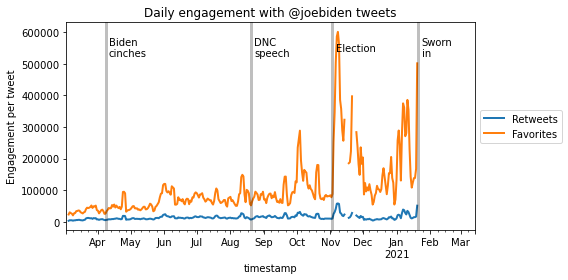

In [179]:
c1 = ~df['retweeted']
c2 = df['reply_id'].isnull()

pure_tweets_df = df[c1 & c2]
print("There are {0:,} tweets that are not retweets or replies.".format(len(pure_tweets_df)))

_s = pure_tweets_df.groupby(pd.Grouper(key='timestamp',freq='1D')).agg({'retweets':'sum','favorites':'sum','id':len})
_s = _s[['retweets','favorites']].div(_s['id'],axis=0)
_s.columns = ['Retweets','Favorites']

# Make the plot
f,ax = plt.subplots(1,1,figsize=(8,4))
ax = _s.rolling(3).mean().plot(legend=False,lw=2,ax=ax)
# ax.set_yscale('symlog')
# ax.set_ylim((1e1,1e6))

ax.legend(loc='center left',bbox_to_anchor=(1,.5))
ax.set_title('Daily engagement with @joebiden tweets')
ax.set_ylabel('Engagement per tweet')

# Annotate the plot with lines corresponding to major events
ax.axvline(pd.Timestamp('2020-04-08'),lw=3,c='k',alpha=.25) # Biden cinches
ax.axvline(pd.Timestamp('2020-08-20'),lw=3,c='k',alpha=.25) # DNC speech
ax.axvline(pd.Timestamp('2020-11-03'),lw=3,c='k',alpha=.25) # Election day
ax.axvline(pd.Timestamp('2021-01-21'),lw=3,c='k',alpha=.25) # Swearing in
    
_y = 5.5e5
ax.text(x=pd.Timestamp('2020-04-08')+pd.Timedelta(3,'d'),y=_y,s='Biden\ncinches',va='center')
ax.text(x=pd.Timestamp('2020-08-20')+pd.Timedelta(3,'d'),y=_y,s='DNC\nspeech',va='center')
ax.text(x=pd.Timestamp('2020-11-03')+pd.Timedelta(3,'d'),y=_y,s='Election',va='center')
ax.text(x=pd.Timestamp('2021-01-21')+pd.Timedelta(3,'d'),y=_y,s='Sworn\nin',va='center')

f.tight_layout()
# f.savefig('aoc_engagement_no_rt_reply.png',dpi=300,bbox_inches='tight')

Plot favorites per retweet.

Text(2021-01-24 00:00:00, 0.45, 'Sworn\nin')

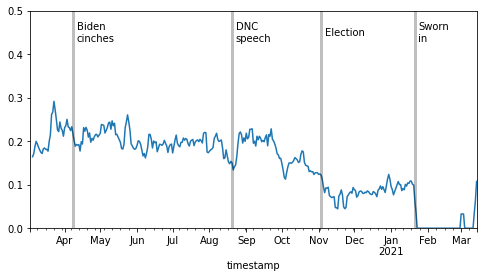

In [185]:
f,ax = plt.subplots(1,1,figsize=(8,4))

(_s['Retweets']/_s['Favorites']).fillna(0).rolling(3).mean().plot(ax=ax)

ax.set_ylim((0,.5))

# Annotate the plot with lines corresponding to major events
ax.axvline(pd.Timestamp('2020-04-08'),lw=3,c='k',alpha=.25) # Biden cinches
ax.axvline(pd.Timestamp('2020-08-20'),lw=3,c='k',alpha=.25) # DNC speech
ax.axvline(pd.Timestamp('2020-11-03'),lw=3,c='k',alpha=.25) # Election day
ax.axvline(pd.Timestamp('2021-01-21'),lw=3,c='k',alpha=.25) # Swearing in
    
_y = .45
ax.text(x=pd.Timestamp('2020-04-08')+pd.Timedelta(3,'d'),y=_y,s='Biden\ncinches',va='center')
ax.text(x=pd.Timestamp('2020-08-20')+pd.Timedelta(3,'d'),y=_y,s='DNC\nspeech',va='center')
ax.text(x=pd.Timestamp('2020-11-03')+pd.Timedelta(3,'d'),y=_y,s='Election',va='center')
ax.text(x=pd.Timestamp('2021-01-21')+pd.Timedelta(3,'d'),y=_y,s='Sworn\nin',va='center')

What are the top tweets by retweets per favorite? The're primarily from before her primary win.

In [187]:
df['rt_fav_ratio'] = (df['retweets']/df['favorites']).replace({np.inf:np.nan})
top_retweets = df['rt_fav_ratio'].dropna().sort_values(ascending=False).head(10)
df.loc[top_retweets.index,['created','text','retweets','favorites']]

,created,text,retweets,favorites
2922,2020-04-03 14:40:00+00:00,Wisconsin — you have until 5 PM CT tonight to ...,3123,5662
2462,2020-05-24 01:56:00+00:00,"Nearly 100,000 lives have been lost, and tens ...",82282,161998
3034,2020-03-21 17:29:00+00:00,Everyone knows that we're facing a real crisis...,40481,81670
2794,2020-04-17 19:02:00+00:00,President Trump is trying to rewrite history w...,25014,54913
3095,2020-03-16 01:17:11+00:00,Bernie Sanders voted against comprehensive imm...,3125,7010
1422,2020-09-18 15:15:00+00:00,"Donald Trump claimed he would be ""the greatest...",28029,63159
2944,2020-03-31 21:01:00+00:00,"In the midst of a pandemic, the Trump Administ...",5499,12639
1400,2020-09-20 20:16:00+00:00,Our frontline workers have sacrificed so much ...,15264,35169
2932,2020-04-01 23:47:00+00:00,At a time when Americans might need health car...,12890,29992
1069,2020-10-13 16:35:00+00:00,If you live in:\n\nKansas\nLouisiana\nMaryland...,8787,20980


Is there an intereseting relationship between seniment and retweet/favorite ratio? We can specify a simple univariate LOESS regression for the relationship between sentiment and the retweet-per-favorite ratio. It appears that extremely negative and positive tweets have higher ratios than neutral tweets.

(0.0, 0.6)

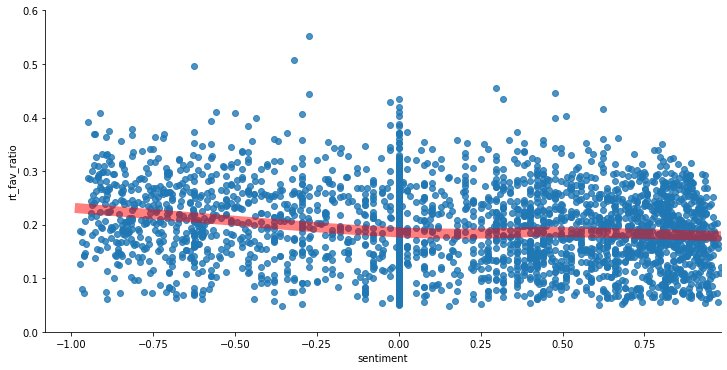

In [189]:
g = sb.lmplot(x='sentiment',y='rt_fav_ratio',data=df,lowess=True,aspect=2,
              line_kws={'color':'red','linewidth':10,'alpha':.5})
ax = g.axes[0,0]
ax.set_ylim((0,.6))

## Pulling a user's friends

In the parlance of the Twitter API, the people who follow an account are "followers" and the people followed by an account are "friends". There's unfortuantely no timestamp meta-data about when friend and follower relationships were created. The API limits on this are much more stringent than other API calls: only 200 accounts per request and only 15 requests per 15-minute window: basically 200 accounts per minute or 3,000 accounts before you hit the rate limit. AOC has 1,417 friends, so it takes 8 API requests to get them all, leaving me with 7 requests in this 15-minute window.

In [205]:
friends = api.friends.list(screen_name='joebiden',count=200,skip_status=True)
print("There are {0:,} friends.".format(len(friends['users'])))

There are 46 friends.


In [195]:
[u['screen_name'] for u in friends['users']]

['POTUS',
 'teachcardona',
 'AliMayorkas',
 'ABlinken',
 'SecYellen',
 'neeratanden',
 'XavierBecerra',
 'mlfudge',
 'DenisMcDonough',
 'PeteButtigieg',
 'DebHaalandNM',
 'JenGranholm',
 'Michael_S_Regan',
 'SecDef',
 'Mariska',
 'BidenInaugural',
 'WhiteHouse',
 'BlueAmerica22',
 'DouglasEmhoff',
 'KamalaHarris',
 'JoeForNV',
 'JoeForSC',
 'JoeForNH',
 'JoeForIA',
 'TeamJoe',
 'De11eDonne',
 'ladygaga',
 'ItsOnUs',
 'DrBiden',
 'UDBidenInst',
 'BidenCancer',
 'PennBiden',
 'ObamaFoundation',
 'livelihood2017',
 'bidenfoundation',
 'timkaine',
 'HillaryClinton',
 'DrBiden44',
 'WhiteHouse45',
 'ObamaWhiteHouse',
 'VP44',
 'VP45',
 'BeauBidenFdn',
 'TheDemocrats',
 'MichelleObama',
 'BarackObama']

We can check my API rate limit status too.

In [198]:
api.application.rate_limit_status()['resources']['friends']['/friends/list']

{'limit': 15, 'remaining': 13, 'reset': 1616649680}

In [201]:
datetime.fromtimestamp(api.application.rate_limit_status()['resources']['friends']['/friends/list']['reset'])

datetime.datetime(2021, 3, 24, 23, 21, 20)

I think "friends" convey much more valuable information about an account than followers, primarily because an account doesn't choose who follows them. However, if you wanted to get the followers of an account, we use the `GetFollowers` method. I'm only going to grab 200 so I don't burn more API calls.

In [202]:
followers = api.followers.list(screen_name='joebiden',skip_status=True,total_count=200)

In [204]:
api.application.rate_limit_status()['resources']['followers']['/followers/list']

{'limit': 15, 'remaining': 14, 'reset': 1616649864}

We can access these user objects to pull out interesting meta-data.

In [210]:
friends['users'][0]['screen_name']

'POTUS'

In [211]:
friends['users'][0]['description']

'46th President of the United States, husband to @FLOTUS, proud dad & pop. Tweets may be archived: https://t.co/IURuMIrzxb'

In [212]:
friends['users'][0]['name']

'President Biden'

In [213]:
friends['users'][0]['created_at']

'Wed Jan 13 00:37:08 +0000 2021'

In [214]:
friends['users'][0]['statuses_count']

402

In [215]:
friends['users'][0]['followers_count']

9416917

In [216]:
friends['users'][0]['friends_count']

12

In [217]:
friends['users'][0]['verified']

True

In [218]:
friends['users'][0]['id']

1349149096909668363

Loop through all the friends of @aoc and turn it into a DataFrame.

In [223]:
friends_payloads = []

for friend in friends['users']:
    p = {}
    p['name'] = friend['name']
    p['description'] = friend['description']
    p['screen_name'] = friend['screen_name']
    p['created_at'] = friend['created_at']
    p['statuses_count'] = friend['statuses_count']
    p['followers_count'] = friend['followers_count']
    p['friends_count'] = friend['friends_count']
    p['verified'] = friend['verified']
    p['id'] = friend['id']
    friends_payloads.append(p)
    
friends_df = pd.DataFrame(friends_payloads)
friends_df['created_at'] = pd.to_datetime(friends_df['created_at'])
friends_df['created_at'] = friends_df['created_at'].dt.tz_convert(None)
friends_df['account_age'] = friends_df['created_at'].apply(lambda x:(datetime.now() - x)/pd.Timedelta(1,'d'))
friends_df.head()

,name,description,screen_name,created_at,statuses_count,followers_count,friends_count,verified,id,account_age
0,President Biden,"46th President of the United States, husband t...",POTUS,2021-01-13 00:37:08,402,9416917,12,True,1349149096909668363,70.941707
1,Dr. Miguel A. Cardona,"Husband, Father of 2, Secretary of Education, ...",teachcardona,2012-08-17 13:56:53,552,69965,300,True,763766437,3141.386325
2,Alejandro Mayorkas,"Former DHS Deputy Secretary, Dad, Husband, Imm...",AliMayorkas,2020-11-23 13:57:45,11,162731,10,True,1330873099424854017,121.385723
3,Antony Blinken,Secretary of State nominee for Biden administr...,ABlinken,2012-07-14 20:29:35,2095,393592,876,True,635716830,3175.113617
4,Secretary Janet Yellen,78th Secretary of the Treasury. Former Fed Cha...,SecYellen,2020-11-29 22:12:26,48,249633,69,True,1333171793201225728,115.042193


In this sample of Twitter accounts, are there any interesting trends in verified accounts?

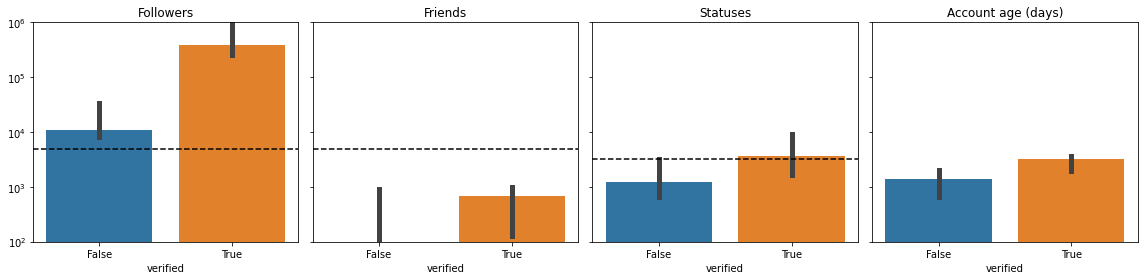

In [225]:
f,axs = plt.subplots(1,4,figsize=(16,4),sharey=True)

sb.barplot(x='verified',y='followers_count',data=friends_df,ax=axs[0],estimator=np.median,errwidth=5)
sb.barplot(x='verified',y='friends_count',data=friends_df,ax=axs[1],estimator=np.median,errwidth=5)
sb.barplot(x='verified',y='statuses_count',data=friends_df,ax=axs[2],estimator=np.median,errwidth=5)
sb.barplot(x='verified',y='account_age',data=friends_df,ax=axs[3],estimator=np.median,errwidth=5)

axs[0].set_title('Followers')
axs[1].set_title('Friends')
axs[2].set_title('Statuses')
axs[3].set_title('Account age (days)')

# As we'll see below, having more than 5,000 friends could complicate our sampling
axs[0].axhline(5000,ls='--',c='k')
axs[1].axhline(5000,ls='--',c='k')
axs[2].axhline(3200,ls='--',c='k')

for ax in axs:
    ax.set_ylim((1e2,1e6))
    ax.set_yscale('symlog')
    ax.set_ylabel(None)

f.tight_layout()

Are these differences statistically-significant? Let's run some [t-tests](https://en.wikipedia.org/wiki/T-test).

In [228]:
from scipy import stats

for var in ['followers_count','friends_count','statuses_count','account_age']:
    vals1 = friends_df.loc[friends_df['verified'] == True,var]
    vals2 = friends_df.loc[friends_df['verified'] == False,var]
    test,pvalue = stats.ttest_ind(vals1,vals2)
    str_fmt = "The differences in {0}: t = {1:.2f} \t p={2:.3f}"
    print(str_fmt.format(var,test,pvalue))

The differences in followers_count: t = 1.16 	 p=0.253
The differences in friends_count: t = 0.60 	 p=0.550
The differences in statuses_count: t = 1.38 	 p=0.175
The differences in account_age: t = 2.69 	 p=0.010


Or use the non-parametric [Mann-Whitney U-test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) since our data is so skewed.

In [229]:
for var in ['followers_count','friends_count','statuses_count','account_age']:
    vals1 = friends_df.loc[friends_df['verified'] == True,var]
    vals2 = friends_df.loc[friends_df['verified'] == False,var]
    test,pvalue = stats.mannwhitneyu(vals1,vals2)
    str_fmt = "The differences in {0}: U = {1:,.0f} \t p = {2:,.3f}"
    print(str_fmt.format(var,test,pvalue))

The differences in followers_count: U = 19 	 p = 0.000
The differences in friends_count: U = 106 	 p = 0.048
The differences in statuses_count: U = 99 	 p = 0.032
The differences in account_age: U = 73 	 p = 0.005


Unsurprisingly, verified accounts have more followers and are older than non-verified accounts. But they also appear to be more active and have more friends.

### Ego-network
We can make a 1.5-step ego-network of the accounts @aoc follows and the accounts each of them follow. Using the `GetFriends` is too "expensive" because it cost us 8 API calls to get a single account's followers since it only returns 200 accounts at a time. Twitter also exposes a [get friends/ids](https://developer.twitter.com/en/docs/accounts-and-users/follow-search-get-users/api-reference/get-friends-ids) end-point that will return up to 5,000 user IDs per request. The number of requests remains 15 requests per 15-minute window, but we can now get the friend networks for 15 accounts per 15 minutes rather than maybe only 1 or 2. The challenge with this is that we will need to "rehydrate" these user IDs at some point.

Here, we'll use the "total_count" parameter to limit it to 5,000 accounts in case one of these accounts follows thousands of accounts. 

Store the data in a dictionary keyed by account name and with the list of user IDs integers as values. Initialize with @aoc.

In [78]:
aoc_friends_d = {'aoc':api.GetFriendIDs(screen_name='aoc',total_count=5000,count=5000)}

In [79]:
api.rate_limit.resources

{'users': {'/users/show/:id': {'limit': 900,
   'remaining': 899,
   'reset': 1550093800}},
 'statuses': {'/statuses/show/:id': {'limit': 900,
   'remaining': 899,
   'reset': 1550094210},
  '/statuses/lookup': {'limit': 900, 'remaining': 898, 'reset': 1550094938},
  '/statuses/user_timeline': {'limit': 900,
   'remaining': 881,
   'reset': 1550095411}},
 'friends': {'/friends/list': {'limit': 15,
   'remaining': 7,
   'reset': 1550096241},
  '/friends/ids': {'limit': 15, 'remaining': 14, 'reset': 1550096667}},
 'followers': {'/followers/list': {'limit': 15,
   'remaining': 14,
   'reset': 1550096362}}}

In [81]:
aoc_friends_d['aoc']

[61843868,
 114870265,
 22709207,
 1080854064567668736,
 806906355214852096,
 1079802482640019456,
 713217283246530560,
 78706973,
 2468096389,
 3321135820,
 28796289,
 47646735,
 516880804,
 305307067,
 24506246,
 175183717,
 240812994,
 95270375,
 5770442,
 217708411,
 829760984,
 180681251,
 103018203,
 124628664,
 953642468028841984,
 140519774,
 1079769536730140672,
 120342217,
 297067961,
 27789237,
 586291040,
 7141302,
 16341344,
 19034656,
 25694156,
 80612021,
 216921189,
 453495356,
 26668729,
 1071545951414820865,
 22799750,
 787373558,
 31122582,
 771152516,
 92116069,
 1078692057940742144,
 19638752,
 821782476515409920,
 192942213,
 2431547652,
 148002957,
 817113,
 2853910604,
 853229442,
 19086859,
 70740986,
 26642006,
 15907183,
 2461810448,
 40557819,
 839226269627621376,
 15446551,
 29201047,
 377609596,
 35761681,
 76545283,
 47767146,
 749303,
 1394944982,
 6974622,
 14984637,
 2970279814,
 109025212,
 1067826316622405633,
 2372139020,
 35586563,
 765735376912719

Check there's still something like 1,400 for "aoc".

In [80]:
len(aoc_friends_d['aoc'])

1422

How many accounts have more than 5000 friends? So about 10% of our network will be incomplete if we limit to only a single "page" of 5,000 user IDs per follower.

In [82]:
gt5000_aoc_friend_df = aoc_friend_df[aoc_friend_df['friends_count'] > 5000]
len(gt5000_aoc_friend_df)

147

Who are some of these high-friend accounts? Even at 5,000 friends per request, it will still cost you 123 API requests (and thus 123 minutes) to get Barack Obama's 615,000 friends.

In [83]:
subset_cols = ['name','screen_name','friends_count','followers_count','description']
gt5000_aoc_friend_df.sort_values('friends_count',ascending=False).head(10)[subset_cols]

,name,screen_name,friends_count,followers_count,description
1295,Taye Diggs,TayeDiggs,661644,639662,I'm serious chocolate and don't get it twisted...
1225,Barack Obama,BarackObama,615828,104589725,"Dad, husband, President, citizen."
978,Soledad O'Brien,soledadobrien,453851,933678,"Thank you, next."
410,Twitter Verified,verified,315125,2609343,Twitter is working on a new authentication and...
1169,Millennial Politics,MillenPolitics,92956,111300,"Shining a spotlight on progressive candidates,..."
109,Cory Booker,CoryBooker,92840,4169740,U.S. senator from New Jersey and Democratic ca...
1168,Nathan H. Rubin,NathanHRubin,74929,79562,"Founder, @MillenPolitics. Young Leaders Board,..."
1248,NPR,NPR,71247,7674341,News. Arts & Life. Music. Everything and more ...
726,Elianne Ramos,ergeekgoddess,69115,54210,Hopelessly Undomestic | Speaker | Public Affai...
915,PBS,PBS,51181,2253150,PBS invites you to discover new ideas and expl...


This loop will go through the list of `aoc_friends` (a list of `User` objects) and then get the 5,000 friends' user IDs for each of them. With these rate limits of 15 requests per 15 min, it will take 1417 minutes (23.6 hours) to get our sample of data for AOC's 1,417 friends. You can now start to see the appeal of parallelizing requests!

You probably don't want to run this loop.

Instead, I've done this scraping for you and saved the results in a JSON file.

In [84]:
with open('aoc_friend_ids2.json','r') as f:
    aoc_friends_d = json.load(f)

Now we want to make a network of who follows whom.

In [85]:
friends_l = []

# Turn the dictionary into an edgelist
for user_id, friend_ids in aoc_friends_d.items():
    for friend_id in friend_ids:
        friends_l.append((str(user_id),str(friend_id)))
        
# Turn the list of dictionaries into a DataFrame
friends_df = pd.DataFrame(friends_l,columns=['user_id','friend_id'])

# Get the unique user_ids for AOC's friends
unique_friend_ids = friends_df['user_id'].unique()

# Just keep friends of AOC in the list
# Throw away friends of friends who aren't direct friends of AOC
subset_friends_df = friends_df[friends_df['friend_id'].isin(unique_friend_ids)]

# Print out number of edges remaining
print('Edges before: {:,}'.format(len(friends_df)),'\nEdges after: {:,}'.format(len(subset_friends_df)))

Edges before: 2,573,446 
Edges after: 160,041


Map the numeric user_id back to screen_name.

In [88]:
ids_to_screen_name_map = {str(user.id):user.screen_name for user in aoc_friends}
ids_to_screen_name_map['138203134'] = 'aoc'

Building on the [shared audience measure](http://faculty.washington.edu/kstarbi/Stewart_Starbird_Drawing_the_Lines_of_Contention-final.pdf) used by Stewart, *et al.* (2017), I computed [Jaccard coefficients](https://en.wikipedia.org/wiki/Jaccard_index) for the friend sets of each account. The intuituion here is that if two accounts are friends with all the same accounts, their score would be 1 while if two accounts had no friends in common, their score would be 0. This has the benefit of giving us a numerical weight to otherwise binary friend relationships: friend relations are "stronger" if they are more strongly embedded in a network with other overlapping friend relations and "weaker" if there is less overlap. This requires pair-wise evaluations of $1420*1419=2,014,980$ combinations, which takes about 20 minutes on my computer.

I've saved you the time and you can read in these pairwise Jaccard similarities from disk.

In [86]:
friend_jaccard_df = pd.read_csv('aoc_all_friend_jaccard.csv',index_col=0,
                                dtype={'user':str,'friend':str,'jaccard':float})

friend_jaccard_df.head()

/Users/briankeegan/anaconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,user,friend,jaccard
0,138203134,1080854064567668736,0.059829
1,138203134,806906355214852096,0.048734
2,138203134,1079802482640019456,0.049516
3,138203134,713217283246530560,0.020949
4,138203134,78706973,0.028120


We can combine the `subset_friends_df` with `friend_jaccard_df` using pandas's [`merge`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) command.

In [89]:
# Left-join the subset_friends and friend_jaccard DataFrames
friend_el = pd.merge(subset_friends_df,
                     friend_jaccard_df,
                     left_on=['user_id','friend_id'],
                     right_on=['user','friend'],how='left')

# Keep a few columns
friend_el = friend_el[['user','friend','jaccard']]

# Map the user_ids back to screen_names
friend_el['user'] = friend_el['user'].apply(str).map(ids_to_screen_name_map)
friend_el['friend'] = friend_el['friend'].apply(str).map(ids_to_screen_name_map)

# Save to disk
friend_el.to_csv('aoc_friends_edgelist.csv')

# Inspect
friend_el.tail()

,user,friend,jaccard
160036,DeanElmore,jsmooth995,0.006267
160037,DeanElmore,xeni,0.004169
160038,DeanElmore,lessig,0.005323
160039,DeanElmore,alex11shuck,0.058063
160040,DeanElmore,TEDTalks,0.011236


We are going to use the [`networkx`](https://networkx.github.io/documentation/stable/) (that should come with Anaconda by default) to convert this edgelist into a Graph object.

In [90]:
# Import networkx
import networkx as nx

This raw network is very dense: there are about 100 times more edges than nodes. A general heuristic for graph visualization is you want the number of nodes and edges to be about the same order of magnitude to prevent [overplotting](https://www.displayr.com/what-is-overplotting/).

In [94]:
g_dense = nx.from_pandas_edgelist(friend_el,source='user',target='friend',create_using=nx.Graph)
print("There are {0:,} nodes and {1:,} edges.".format(g_dense.number_of_nodes(),g_dense.number_of_edges()))
nx.write_gexf(g_dense,'aoc_all_friends.gexf')

There are 1,387 nodes and 130,580 edges.


The distribution of Jaccard scores we computed is very skewed. We can now use these similarity scores to filter out "weaker" edges. We are effectively throwing away all of the data to the left of the dashed line at the 95% percentile to help us with visualization.

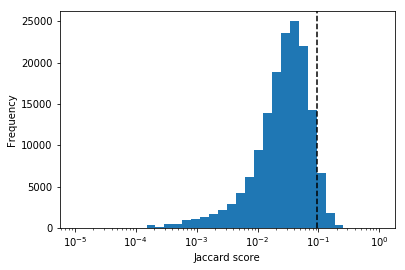

In [92]:
ax = friend_el['jaccard'].plot(kind='hist',bins=np.logspace(-5,0,35))
ax.set_xscale('log')
ax.set_xlabel('Jaccard score')
ax.axvline(np.percentile(friend_el['jaccard'],95),c='k',ls='--')

Keep only the top 5% of edges for visualization purposes.

In [93]:
# Keep only the top 5% of edges by Jaccard coefficients
top_friend_el = friend_el[friend_el['jaccard'] > np.percentile(friend_el['jaccard'],95)]

# Write these top edges into the network
g = nx.from_pandas_edgelist(top_friend_el,source='user',target='friend',edge_attr=True,create_using=nx.Graph)
print("There are {0:,} nodes and {1:} edges.".format(g.number_of_nodes(),g.number_of_edges()))

# Save to disk
nx.write_gexf(g,'aoc_friends_filtered.gexf')

There are 726 nodes and 4753 edges.


I visualized the network below in [Gephi](https://gephi.org/). We see a distinctive community structure reflecting different identities like local organizations, journalists, national politicians, activist groups, *etc*.

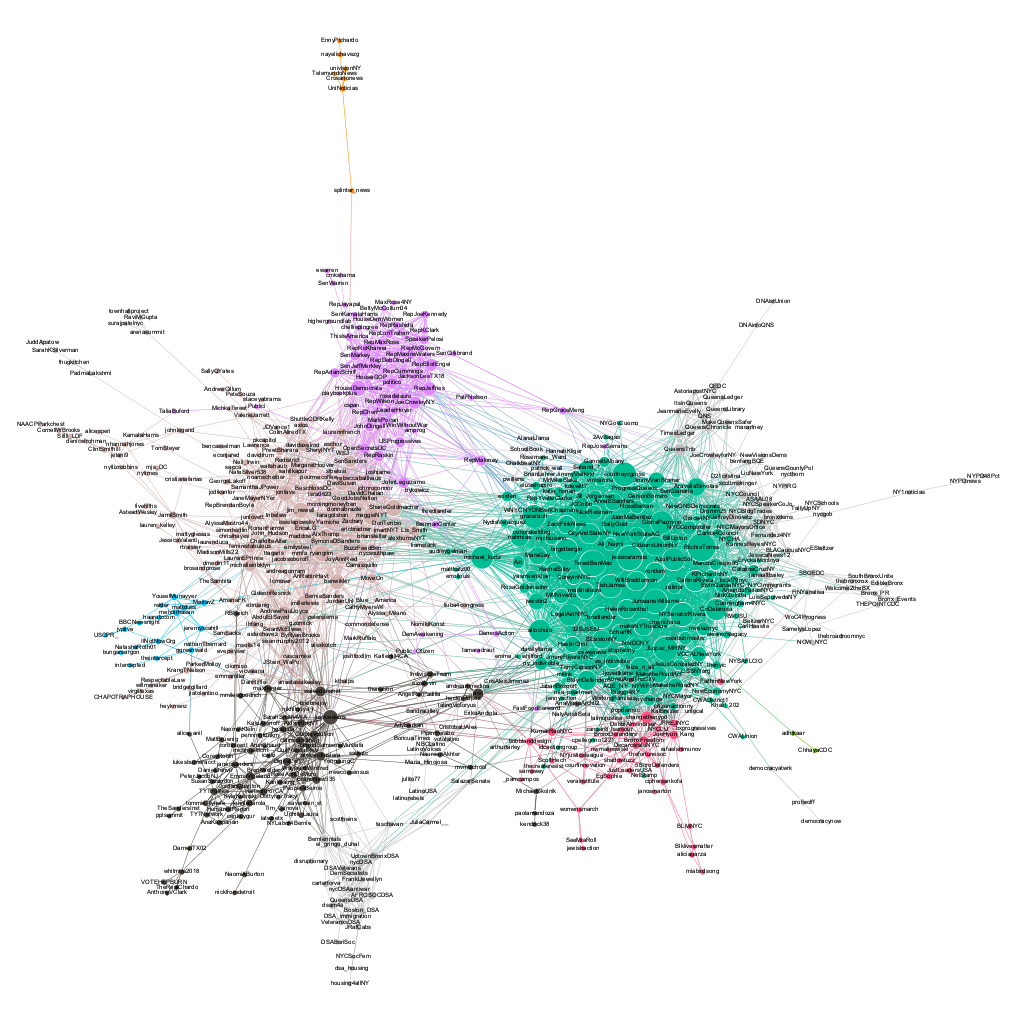

In [208]:
from IPython.display import Image

Image('aoc_friends_filtered.png')

## Using the streaming API

We can also sit on Twitter's [Streaming API](https://developer.twitter.com/en/docs/tweets/sample-realtime/api-reference/get-statuses-sample) and get a sample of tweets that are produced in real time. The `.GetStreamSample()` method returns a [generator](https://wiki.python.org/moin/Generators), which is an advanced type of object that doesn't store any data *per se* but points to successive locations where you can find data. In this case, the generator points to where we can find the next tweet in the sample. For 10,000 tweets on a stream sampling approximately 1% of live tweets, this may take 2–3 minutes.

In [95]:
# Make the generator
stream = api.GetStreamSample()

# Make an empty list to store the tweet statuses
stream_list = []

# Start iterating through the stream
for status in stream:
    
    # As long as we have fewer than this many tweets
    if len(stream_list) < 1000:
        
        # And if it's not a delete status request
        if 'delete' not in status:
        
            # Add another tweet to our list
            stream_list.append(status)
        
    # Otherwise stop
    else:
        break
        
"There are {0:,} tweets from the stream.".format(len(stream_list))

'There are 1,000 tweets from the stream.'

Look at one of our statuses.

In [96]:
stream_list[0]

{'created_at': 'Wed Feb 13 22:43:13 +0000 2019',
 'id': 1095815686813712384,
 'id_str': '1095815686813712384',
 'text': 'ぼぶてぃる♪さん、あや♥さん、ここのえとわさん(@cabbageroll_0x0)といっしょにA・I・K・A・T・S・U!でごいっしょしました(*´ω｀*) https://t.co/cbMs921CTU',
 'display_text_range': [0, 78],
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'truncated': False,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 1012875342434918400,
  'id_str': '1012875342434918400',
  'name': 'まみこさん',
  'screen_name': 'mamikostars80',
  'location': None,
  'url': None,
  'description': 'まみこさんのアイドル活動(撮りカツ)用アカウントです。フレンズ名はハープスター(こと座の一等星の別名より)。アイコン:けちゃっぷさん(@ketchup_prpr)、ヘッダー:しおりんさん(@dollydevilsor)より☆',
  'translator_type': 'none',
  'protected': False,
  'verified': False,
  'followers_count': 43,
  'friends_count': 46,
  'listed_count': 1,
  'favourites_count': 62

Because these dictionaries represent raw JSON rather than cute `Status` objects, we need to adapt our loop from above that turns tweet statuses into a flat DataFrame. (I warned you!)

In [97]:
def tweet_cleaner(status):
    payload = {}
    payload['screen_name'] = status['user']['screen_name']
    payload['created'] = pd.to_datetime(status['created_at'])
    payload['retweets'] = status['retweet_count']
    payload['favorites'] = status['favorite_count']
    payload['id'] = status['id']
    payload['reply_screen_name'] = status['in_reply_to_screen_name']
    payload['reply_id'] = status['in_reply_to_status_id']
    payload['source'] = BeautifulSoup(status['source']).text
    payload['lang'] = status['lang']
    
    if status['place']:
        payload['place'] = status['place']['country']
    else:
        payload['place'] = None

    if len(status['entities']['user_mentions']) > 0:
        payload['user_mentions'] = '; '.join([m['screen_name'] for m in status['entities']['user_mentions']])
    else:
        payload['user_mentions'] = None

    if len(status['entities']['hashtags']) > 0:
        payload['hashtags'] = '; '.join([h['text'] for h in status['entities']['hashtags']])
    else:
        payload['hashtags'] = None

    # If an account retweets another account, we should store that information
    if 'retweeted_status' in status:
        rt_status = status['retweeted_status']
        if 'extended_tweet' in rt_status:
            payload['text'] = rt_status['extended_tweet']['full_text']
            if len(rt_status['extended_tweet']['entities']['hashtags']) > 0:
                payload['hashtags'] = '; '.join([h['text'] for h in rt_status['extended_tweet']['entities']['hashtags']])
            else:
                payload['hashtags'] = None
        else:
            try:
                payload['text'] = rt_status['text']
            except:
                payload['text'] = rt_status['full_text']
            if len(rt_status['entities']['hashtags']) > 0:
                payload['hashtags'] = '; '.join([h['text'] for h in rt_status['entities']['hashtags']])
            else:
                payload['hashtags'] = None
        payload['is_retweet'] = True
        payload['retweeted_screen_name'] = rt_status['user']['screen_name']
        payload['retweeted_created'] = rt_status['created_at']
        payload['retweeted_source'] = BeautifulSoup(rt_status['source']).text
        
    else:
        if status['truncated']:
            payload['text'] = status['extended_tweet']['full_text']
        else:
            try:
                payload['text'] = status['text']
            except:
                payload['text'] = status['full_text']
        payload['is_retweet'] = False
        payload['retweeted_screen_name'] = False
        payload['retweeted_created'] = False
        payload['retweeted_source'] = False

    return payload

Loop through our list of dictionaries (including the delete stream objects) and flatten the dictionaries out into something we can read into a DataFrame. Include some exception handling that will keep track of which tweets throw errors and prints out the first 50 of those tweet's index position in the `stream_list` for us to diagnose.

In [98]:
stream_statuses_flat = []
errors = []

for i,status in enumerate(stream_list):
    try:
        payload = tweet_cleaner(status)
        stream_statuses_flat.append(payload)
    except:
        errors.append(str(i))

if len(errors) == 0:
    print("There were no errors!")
else:
    print("There were errors at the following indices:", '; '.join(errors[:50]))

There were no errors!


Make our DataFrame, clean up some columns, and make some new ones.

In [99]:
stream_df = pd.DataFrame(stream_statuses_flat)
stream_df['created'] = pd.to_datetime(stream_df['created'])
stream_df['created'] = stream_df['created'].dt.tz_convert(None)
stream_df.tail()

,created,favorites,hashtags,id,is_retweet,lang,place,reply_id,reply_screen_name,retweeted_created,retweeted_screen_name,retweeted_source,retweets,screen_name,source,text,user_mentions
995,2019-02-13 22:43:36,0,None,1095815783278673920,True,en,None,NaN,None,Wed Feb 13 14:19:49 +0000 2019,SevilleCalculat,Twitter for iPhone,0,SteRed5,Twitter for Android,Alan Power - no action\nPaul McGinn - no actio...,SevilleCalculat
996,2019-02-13 22:43:36,0,None,1095815783278628865,True,en,None,NaN,None,Tue Feb 12 04:47:16 +0000 2019,GabrielaYukito,Twitter for Android,0,_Shakirah_,Twitter for iPhone,I hate having one of these dreams. 😂 https://t...,GabrielaYukito
997,2019-02-13 22:43:36,0,None,1095815783274475521,False,en,None,NaN,None,False,False,False,0,shylean6,Twitter for iPhone,Love you,None
998,2019-02-13 22:43:36,0,None,1095815783257702400,False,es,None,NaN,None,False,False,False,0,toschimattia,Twitter for iPhone,Casinista 😂,None
999,2019-02-13 22:43:36,0,None,1095815783291199488,False,pt,None,1.095815e+18,murilovgsouza,False,False,False,0,luanaaraujo280,Twitter for Android,@murilovgsouza @dudhadadd É foda. E não fico f...,murilovgsouza; dudhadadd


Where are people writing their tweets in this sample?

In [101]:
stream_df['source'].value_counts().head(20)

Twitter for iPhone        383
Twitter for Android       367
Twitter Web Client        102
Twitter Web App            29
Twitter for iPad           17
twittbot.net               14
IFTTT                      10
تطبيق قرآني                 8
Curious Cat                 7
TweetDeck                   7
Facebook                    6
Takane Shijou               4
feather for iOS             3
تطبيــق دعـــاء             2
Twitcom - Comunidades       2
on TheWorld                 2
CareerArc 2.0               2
今日のツイライフ                    2
Echoes Act2                 2
WordPress.com               2
Name: source, dtype: int64

What languages are these tweets in?

In [102]:
stream_df['lang'].value_counts().head(10)

en     363
ja     170
pt     109
es      96
und     70
ar      55
fr      25
ko      18
tr      16
th      14
Name: lang, dtype: int64

If a tweet is geolocated, where is it?

In [104]:
stream_df['place'].value_counts()

United States     5
Egypt             2
Italia            1
日本                1
Canada            1
Brasil            1
Estados Unidos    1
España            1
België            1
Argentina         1
United Kingdom    1
Name: place, dtype: int64

In [105]:
stream_df[stream_df['place'] == 'Estados Unidos']

,created,favorites,hashtags,id,is_retweet,lang,place,reply_id,reply_screen_name,retweeted_created,retweeted_screen_name,retweeted_source,retweets,screen_name,source,text,user_mentions
16,2019-02-13 22:43:14,0,None,1095815690995478529,False,und,Estados Unidos,1.095815e+18,clairearenass,False,False,False,0,iVictorManuel__,Twitter for iPhone,@clairearenass @kbvnks_ Brrrrr @clairearenass,clairearenass; kbvnks_; clairearenass


How many tweets are retweets?

In [106]:
stream_df['is_retweet'].value_counts()

True     500
False    500
Name: is_retweet, dtype: int64

How many tweets are replies?

In [107]:
stream_df['reply_id'].notnull().value_counts()

False    805
True     195
Name: reply_id, dtype: int64

Which users are getting a lot of retweets right now?

In [109]:
stream_df['retweeted_screen_name'].value_counts().head(20)

False              500
Nintendo             9
NintendoAmerica      5
Comin4YaHBeanIE      2
Complex              2
frasesdebebada       2
idolshelpffx         2
ermame26             2
rikakoikee           2
Lilartoni            2
Gatita_Kristal1      2
FizzySodaWave        2
BTS_twt              2
louisyacvlrd         1
Scaaaaaaarlet        1
CauseWereGuys        1
dassuenfer           1
BTSLAB_twt           1
yisucristwit         1
Yoshiking_1116       1
Name: retweeted_screen_name, dtype: int64

### Filtered streams

We can also filter the tweets in the stream. Here we only get tweets mentioning "Trump" and that have been auto-classified as written in English.

In [110]:
# Make the generator
filtered_stream = api.GetStreamFilter(track=['Trump'],languages=['en'])

# Make an empty list to store the tweet statuses
filtered_stream_list = []

# What time did we start?
start = time.time()

# Start iterating through the stream
for status in filtered_stream:
    
    # As long as we have fewer than this many tweets
    if len(filtered_stream_list) < 1000:
        
        # And if it's not a delete status request
        if 'delete' not in status:
        
            # Add another tweet to our list
            filtered_stream_list.append(status)
        
    # Otherwise stop
    else:
        break

# What time did we stop?
stop = time.time()
elapsed = stop - start

"There are {0:,} tweets from the stream after {1:.0f} seconds.".format(len(filtered_stream_list),elapsed)

'There are 1,000 tweets from the stream after 35 seconds.'

Clean this up into a DataFrame.

In [111]:
filtered_stream_statuses_flat = []
filtered_errors = []

for i,status in enumerate(filtered_stream_list):
    try:
        payload = tweet_cleaner(status)
        filtered_stream_statuses_flat.append(payload)
    except:
        filtered_errors.append(str(i))

if len(filtered_errors) == 0:
    print("There were no errors!")
else:
    print("There were errors at the following indices:", '; '.join(filtered_errors[:50]))
    
filtered_stream_df = pd.DataFrame(filtered_stream_statuses_flat)
filtered_stream_df['created'] = pd.to_datetime(filtered_stream_df['created'])
filtered_stream_df['created'] = filtered_stream_df['created'].dt.tz_convert(None)
filtered_stream_df.tail()

There were no errors!


,created,favorites,hashtags,id,is_retweet,lang,place,reply_id,reply_screen_name,retweeted_created,retweeted_screen_name,retweeted_source,retweets,screen_name,source,text,user_mentions
995,2019-02-13 22:52:28,0,None,1095818015315320832,False,en,None,1.095297e+18,JohnMurphy51,False,False,False,0,templemore85,Twitter for Android,@JohnMurphy51 I'm amazed they didn't ask Trump...,JohnMurphy51
996,2019-02-13 22:52:28,0,None,1095818014732312576,True,en,None,NaN,None,Wed Feb 13 21:02:36 +0000 2019,charliekirk11,Twitter for iPhone,0,trumpforNC,Twitter for Android,Net worth before running for President:\n\nTru...,charliekirk11
997,2019-02-13 22:52:28,0,None,1095818015617110016,True,en,None,NaN,None,Wed Feb 13 19:05:32 +0000 2019,RBReich,Twitter Web Client,0,herrick_a,Twitter for iPhone,"To the conservative mind, socialism conjures u...",RBReich
998,2019-02-13 22:52:28,0,None,1095818015675953152,True,en,None,NaN,None,Wed Feb 13 16:43:31 +0000 2019,repmarkpocan,Twitter Web Client,0,adamisalamb,Twitter for iPad,President Trump couldn't go to Mar-a-Lago duri...,repmarkpocan
999,2019-02-13 22:52:28,0,None,1095818015893970944,True,en,None,NaN,None,Wed Feb 13 22:14:47 +0000 2019,ananavarro,Twitter for iPad,0,csinp,Twitter for iPhone,"If you didn’t see this live, you must see this...",ananavarro


Let's measure the sentiment of the tweets in this filtered s ample and plot the distribution of their sentiment values.

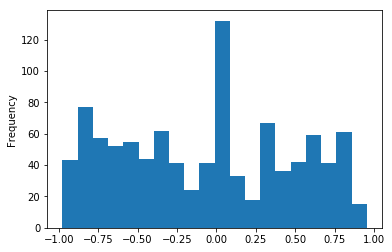

In [112]:
# Compute the sentiment scores
filtered_stream_df['sentiment'] = filtered_stream_df['text'].apply(lambda x:sia.polarity_scores(x)['compound'])

# Plot the distribution
filtered_stream_df['sentiment'].plot(kind='hist',bins=20)

How many retweets in this sample?

In [113]:
filtered_stream_df['is_retweet'].value_counts()

True     795
False    205
Name: is_retweet, dtype: int64

Given the higher fraction of retweets, who is being retweeted?

In [114]:
filtered_stream_df['retweeted_screen_name'].value_counts().head(10)

False              205
charliekirk11       32
krassenstein        30
TheLeadCNN          27
ananavarro          20
Jim_Jordan          16
repmarkpocan        12
realDonaldTrump     12
MarkSimoneNY        11
RealSaavedra         8
Name: retweeted_screen_name, dtype: int64

## Search API

Twitter's [search API](https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets) provides an endpoint to search for tweets matching a query for terms, accounts, hashtags, language, locations, and date ranges. This API endpoint has a rate limit of 180 requests per 15-minute window with 100 statuses per request: or 18,000 statuses per window or 72,000 statuses per hour.

You can explore some of the search functionality through Twitter's [advanced search interface](https://twitter.com/search-advanced). Note that the [standard search API](https://developer.twitter.com/en/docs/tweets/search/overview/standard) only provides a limited access to sample of tweets in the past 7 days, you'll need to pay more to access [historical APIs](https://developer.twitter.com/en/docs/tutorials/choosing-historical-api.html).

In [115]:
api.rate_limit.resources

{'users': {'/users/show/:id': {'limit': 900,
   'remaining': 899,
   'reset': 1550093800}},
 'statuses': {'/statuses/show/:id': {'limit': 900,
   'remaining': 899,
   'reset': 1550094210},
  '/statuses/lookup': {'limit': 900, 'remaining': 898, 'reset': 1550094938},
  '/statuses/user_timeline': {'limit': 900,
   'remaining': 881,
   'reset': 1550095411}},
 'friends': {'/friends/list': {'limit': 15,
   'remaining': 7,
   'reset': 1550096241},
  '/friends/ids': {'limit': 15, 'remaining': 14, 'reset': 1550096667}},
 'followers': {'/followers/list': {'limit': 15,
   'remaining': 14,
   'reset': 1550096362}}}

In [117]:
query = api.GetSearch(term='aoc',count=100,lang='en',result_type='recent',return_json=True)

Loop through these 100 tweets.

In [118]:
search_statuses_flat = []
search_errors = []

for i,status in enumerate(query['statuses']):
    try:
        payload = tweet_cleaner(status)
        search_statuses_flat.append(payload)
    except:
        search_errors.append(str(i))

if len(search_errors) == 0:
    print("There were no errors!")
else:
    print("There were errors at the following indices:", '; '.join(search_errors[:50]))
    
search_df = pd.DataFrame(search_statuses_flat)
# search_df['created'] = pd.to_datetime(search_df['created'])
# search_df['created'] = search_df['created'].dt.tz_convert(None)
search_df.tail()

There were no errors!


,created,favorites,hashtags,id,is_retweet,lang,place,reply_id,reply_screen_name,retweeted_created,retweeted_screen_name,retweeted_source,retweets,screen_name,source,text,user_mentions
95,2019-02-13 22:55:35+00:00,0,None,1095818799125655552,False,en,None,1.095803e+18,nedryun,False,False,False,0,BruceSilver136,Twitter for iPhone,@nedryun @Frenchmarine1 @AOC Her Islamist shar...,nedryun; Frenchmarine1; AOC
96,2019-02-13 22:55:35+00:00,0,None,1095818798299598848,True,en,None,NaN,None,Wed Feb 13 19:16:14 +0000 2019,AOC,Twitter for iPhone,20723,canamrindiudian,Twitter for iPhone,Shock doesn’t begin to cover it.\n\nToday I le...,AOC
97,2019-02-13 22:55:35+00:00,0,AOC,1095818797569720320,False,en,None,NaN,None,False,False,False,0,nanking2100,Twitter Web Client,😆😂🤣 THAT IS HYSTERICAL! I STILL do not know wh...,TheSteveKon
98,2019-02-13 22:55:34+00:00,0,None,1095818795770273792,True,en,None,NaN,None,Wed Feb 13 22:51:29 +0000 2019,JaniceTXBlessed,Twitter Web Client,2,hankentwhistle,Twitter for Android,@Jali_Cat @IlhanMN @Ilhan @SpeakerPelosi @DNC ...,JaniceTXBlessed; Jali_Cat; IlhanMN; Ilhan; Spe...
99,2019-02-13 22:55:34+00:00,0,None,1095818795514560513,True,en,None,NaN,None,Wed Feb 13 22:50:38 +0000 2019,mitchellamunoz,Twitter for iPhone,1,bl_burch,Twitter for iPad,@AOC What’s the problem? Are you thinking of a...,mitchellamunoz; AOC


Write a loop to try to get more tweets. The `query` dictionary includes a sub-dictionary under the "search_metadata" key that includes information about paginating to find the next set of results.

In [119]:
search_tweets = []

while True:
    # When to stop?
    if len(search_tweets) == 2500:
        break
    
    # Get the first set of tweets
    if len(search_tweets) == 0:
        query = api.GetSearch(term='aoc',count=100,lang='en',result_type='recent',return_json=True)
        search_tweets += query['statuses']
        
    # Keep getting tweets
    else:
        # Find the last tweet to use as a max_id
        max_id = search_tweets[-1]['id']
        
        # Get the next set of tweets
        query = api.GetSearch(term='aoc',count=100,lang='en',return_json=True,max_id=max_id - 1)
        
        # Add them to the list of tweets
        search_tweets += query['statuses']
        
print("There are {0:,} tweets in the collection.".format(len(search_tweets)))

There are 2,500 tweets in the collection.


In [120]:
search_statuses_flat = []
search_errors = []

for i,status in enumerate(search_tweets):
    try:
        payload = tweet_cleaner(status)
        search_statuses_flat.append(payload)
    except:
        search_errors.append(str(i))

if len(search_errors) == 0:
    print("There were no errors!")
else:
    print("There were errors at the following indices:", '; '.join(search_errors[:50]))
    
search_df = pd.DataFrame(search_statuses_flat)
search_df['created'] = pd.to_datetime(search_df['created'])
search_df['created'] = search_df['created'].dt.tz_convert(None)
search_df.tail()

There were no errors!


,created,favorites,hashtags,id,is_retweet,lang,place,reply_id,reply_screen_name,retweeted_created,retweeted_screen_name,retweeted_source,retweets,screen_name,source,text,user_mentions
2495,2019-02-13 22:46:38,0,None,1095816546134441985,True,en,None,NaN,None,Wed Feb 13 19:16:14 +0000 2019,AOC,Twitter for iPhone,20746,babsbcd,Twitter for iPhone,Shock doesn’t begin to cover it.\n\nToday I le...,AOC
2496,2019-02-13 22:46:38,0,None,1095816545190793216,True,en,None,NaN,None,Wed Feb 13 19:29:46 +0000 2019,JoyceWhiteVance,Twitter for iPad,590,CTrentham88,Twitter for Android,"@AOC .@AOC, Professor &amp; former head of the...",JoyceWhiteVance; AOC; AOC
2497,2019-02-13 22:46:38,0,ampFW,1095816545111019521,True,en,None,NaN,None,Wed Feb 13 18:20:10 +0000 2019,FreedomWorks,Sprout Social,33,mel54732492,Twitter for Android,".@AOC is trying to ""whistle"" past her atrociou...",FreedomWorks; AOC
2498,2019-02-13 22:46:38,2,None,1095816544003620865,False,en,None,1.095814e+18,KrangTNelson,False,False,False,0,sicktransitw,Twitter Web App,@KrangTNelson And AOC wants to make us like th...,KrangTNelson
2499,2019-02-13 22:46:37,0,None,1095816540480389121,True,en,None,NaN,None,Wed Feb 13 19:16:14 +0000 2019,AOC,Twitter for iPhone,20746,Samuraiturnip,Twitter Web App,Shock doesn’t begin to cover it.\n\nToday I le...,AOC


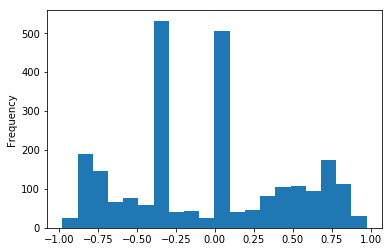

In [121]:
# Compute the sentiment scores
search_df['sentiment'] = search_df['text'].apply(lambda x:sia.polarity_scores(x)['compound'])

# Plot the distribution
search_df['sentiment'].plot(kind='hist',bins=20)

## Detecting bot accounts using Bot-o-meter

Botometer is a tool developed by [researchers at Indiana University](https://osome.iuni.iu.edu/) to evaluate the likelihood of a given account being a bot ([related paper](https://arxiv.org/abs/1703.03107)) based on features like user meta-data, friends, content, sentiment, network, and timing. They provide an API as well as a [Python wrapper](https://github.com/IUNetSci/botometer-python) to use API. At the terminal command line, you'll need to:

`pip install botometer`

You will also need to request an API key from this marketplace: https://rapidapi.com/OSoMe/api/botometer

Once you've done all of this, you can start!

In [122]:
import botometer

botometer_api_key = '924e739af7msh78c742ea41f287dp121424jsnff240670ac73'

bom = botometer.Botometer(mashape_key=botometer_api_key,**twitter_keys)

We can check a single account to see the response object. [Documentation for these different response scores](https://market.mashape.com/OSoMe/botometer/overview#wiki-response-object), but the most relevant information is available under "scores" for both English-specific accounts and universal.

In [123]:
bom_result = bom.check_account('@realdonaldtrump')

bom_result

{'cap': {'english': 0.0012616932230026553, 'universal': 0.0017440333583248883},
 'categories': {'content': 0.14075428846626595,
  'friend': 0.09407699305084682,
  'network': 0.10416612598937423,
  'sentiment': 0.08670851966080818,
  'temporal': 0.2636844399869036,
  'user': 0.02392906059496764},
 'display_scores': {'content': 0.7,
  'english': 0.1,
  'friend': 0.5,
  'network': 0.5,
  'sentiment': 0.4,
  'temporal': 1.3,
  'universal': 0.1,
  'user': 0.1},
 'scores': {'english': 0.025471598156045747,
  'universal': 0.027614042942260764},
 'user': {'id_str': '25073877', 'screen_name': 'realDonaldTrump'}}

For this account, there's only a 3% chance of this account being a bot.

In [124]:
bom_result['scores']

{'english': 0.025471598156045747, 'universal': 0.027614042942260764}

Botometer is limited to 2,000 requests per day per user. Let's get the bot scores for the most-active screen names in our `search_df` sample.

In [127]:
search_screen_name_count = search_df['screen_name'].value_counts()

top_search_screen_names = search_screen_name_count[search_screen_name_count > 3].index.tolist()
top_search_screen_names

['DavisJFox',
 'juliettetorrez',
 'Social411Now',
 'bootystank71469',
 'West_Hypocrisy',
 'katerin98849359',
 'tacoshipsitall',
 'faab64',
 'charlesspires',
 'MichaelM0r0n',
 'Nmharley2',
 'ROFLMAO2',
 'gril887',
 'tsay_youdon',
 'kaisap112',
 'NeverPocahontas']

Loop through these accounts and get the bot scores. This could take a few minutes.

In [128]:
top_search_screen_name_bots = bom.check_accounts_in(top_search_screen_names)

top_search_screen_name_bot_list = []

for screen_name, result in top_search_screen_name_bots:
    top_search_screen_name_bot_list.append({screen_name:result})

I've posted some bot scores for accounts to save us time.

In [241]:
with open('top_search_screen_name_bots.json','r') as f:
    top_search_screen_name_bot_list = json.load(f)

Clean up this data, turn it into a Pandas `Series`, and rank the top scores.

In [134]:
universal_scores = {}
for result in top_search_screen_name_bot_list:
    for screen_name,r in result.items():
        universal_scores[screen_name] = r['scores']['universal']

scores_s = pd.Series(universal_scores).sort_values(ascending=False)

scores_s.sort_values(ascending=False).head(20)

West_Hypocrisy     0.708113
NeverPocahontas    0.433677
Social411Now       0.393746
MichaelM0r0n       0.318419
gril887            0.318419
katerin98849359    0.283782
ROFLMAO2           0.236337
Nmharley2          0.221796
juliettetorrez     0.170132
tacoshipsitall     0.138026
tsay_youdon        0.138026
DavisJFox          0.111167
bootystank71469    0.103286
charlesspires      0.082540
faab64             0.044479
kaisap112          0.037980
dtype: float64

Plot the histogram of scores.

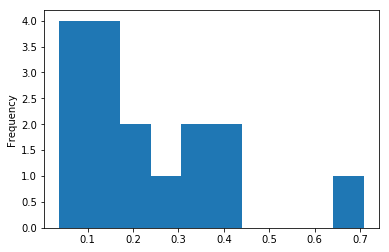

In [135]:
scores_s.plot(kind='hist',bins=10)

In [138]:
sue_user = api.GetUser(screen_name='West_Hypocrisy')

In [139]:
sue_user.created_at

'Sun Aug 19 20:26:45 +0000 2012'

In [140]:
vars(sue_user)

{'param_defaults': {'contributors_enabled': None,
  'created_at': None,
  'default_profile': None,
  'default_profile_image': None,
  'description': None,
  'email': None,
  'favourites_count': None,
  'followers_count': None,
  'following': None,
  'friends_count': None,
  'geo_enabled': None,
  'id': None,
  'id_str': None,
  'lang': None,
  'listed_count': None,
  'location': None,
  'name': None,
  'notifications': None,
  'profile_background_color': None,
  'profile_background_image_url': None,
  'profile_background_image_url_https': None,
  'profile_background_tile': None,
  'profile_banner_url': None,
  'profile_image_url': None,
  'profile_image_url_https': None,
  'profile_link_color': None,
  'profile_sidebar_border_color': None,
  'profile_sidebar_fill_color': None,
  'profile_text_color': None,
  'profile_use_background_image': None,
  'protected': None,
  'screen_name': None,
  'status': None,
  'statuses_count': None,
  'time_zone': None,
  'url': None,
  'utc_offset': No

Let's look at the user timeline for one of these accounts.

In [136]:
# Start with the list of the 200 most-recent tweets
bot_timeline_tweets = api.GetUserTimeline(screen_name='West_Hypocrisy',count=200,include_rts=True)

# Initialize a counter so we don't go overboard with our requests
request_counter = 1

# While our request counter hasn't gone past 16
while request_counter < 17:
    # Get the most oldest tweet id
    final_status_id = bot_timeline_tweets[-1].id
    
    # Pass this tweet ID into the max_id parameter, minus 1 so we don't duplicate it
    bot_timeline_tweets += api.GetUserTimeline(screen_name='West_Hypocrisy',count=200,include_rts=True,max_id=final_status_id-1)
    
    # Increment our request_counter
    request_counter += 1

How many tweets?

In [137]:
"There are {0:,} tweets.".format(len(bot_timeline_tweets))

'There are 2,172 tweets.'

Re-use our code from above to flatten.

In [141]:
bot_statuses_list = []

for status in bot_timeline_tweets:
    if type(status) == twitter.models.Status:
        payload = {}
        payload['screen_name'] = status.user.screen_name
        payload['created'] = pd.to_datetime(status.created_at)
        payload['retweets'] = status.retweet_count
        payload['favorites'] = status.favorite_count
        payload['id'] = status.id
        payload['reply_screen_name'] = status.in_reply_to_screen_name
        payload['reply_id'] = status.in_reply_to_status_id
        payload['source'] = BeautifulSoup(status.source).text
        
        if len(status.user_mentions) > 0:
            payload['user_mentions'] = '; '.join([m.screen_name for m in status.user_mentions])
        else:
            payload['user_mentions'] = None
            
        if len(status.hashtags) > 0:
            payload['hashtags'] = '; '.join([h.text for h in status.hashtags])
        else:
            payload['hashtags'] = None
        
        # If an account retweets another account, we should store that information
        if status.retweeted_status == None:
            payload['text'] = status.full_text
            payload['is_retweet'] = False
            payload['retweeted_screen_name'] = False
            payload['retweeted_created'] = False
        else:
            payload['text'] = status.retweeted_status.full_text
            payload['is_retweet'] = True
            payload['retweeted_screen_name'] = status.retweeted_status.user.screen_name
            payload['retweeted_created'] = status.retweeted_status.created_at
            payload['retweeted_source'] = BeautifulSoup(status.retweeted_status.source).text
            if len(status.retweeted_status.hashtags) > 0:
                payload['hashtags'] = '; '.join([h.text for h in status.retweeted_status.hashtags])
            else:
                payload['hashtags'] = None
        
        bot_statuses_list.append(payload)
        
bot_timeline_df = pd.DataFrame(bot_statuses_list)

Clean up our DataFrame.

In [142]:
bot_timeline_df['timestamp'] = pd.to_datetime(bot_timeline_df['created'])
bot_timeline_df['timestamp'] = pd.to_datetime(bot_timeline_df['timestamp'])
bot_timeline_df['timestamp'] = bot_timeline_df['timestamp'].dt.tz_convert(None)

bot_timeline_df['date'] = bot_timeline_df['timestamp'].apply(lambda x:x.date())
bot_timeline_df['weekday'] = bot_timeline_df['timestamp'].apply(lambda x:x.weekday())
bot_timeline_df['hour'] = bot_timeline_df['timestamp'].apply(lambda x:x.hour)

bot_timeline_df['sentiment'] = bot_timeline_df['text'].apply(lambda x:sia.polarity_scores(x)['compound'])

bot_timeline_df.head()

,created,favorites,hashtags,id,is_retweet,reply_id,reply_screen_name,retweeted_created,retweeted_screen_name,retweeted_source,retweets,screen_name,source,text,user_mentions,timestamp,date,weekday,hour,sentiment
0,2019-02-13 23:09:02+00:00,0,Cameroon; Africa; Ambazonia; humanrights; Came...,1095822184684142594,True,NaN,None,Mon Jul 02 02:50:04 +0000 2018,West_Hypocrisy,Twitter Web Client,50,West_Hypocrisy,Twitter Web Client,#Cameroon #Africa\n\n https://t.co/oL79SqM4hU ...,West_Hypocrisy,2019-02-13 23:09:02,2019-02-13,2,23,0.0258
1,2019-02-13 23:08:56+00:00,0,Media; hypocrisy,1095822156955561984,True,NaN,None,Fri Jan 25 01:40:01 +0000 2019,West_Hypocrisy,Twitter Web Client,51,West_Hypocrisy,Twitter Web Client,Italy Accuses France of ‘Impoverishing Africa’...,West_Hypocrisy,2019-02-13 23:08:56,2019-02-13,2,23,-0.6608
2,2019-02-13 23:08:50+00:00,0,slaughter; tortures; Cameroon; Africa; UN; Fra...,1095822130846019591,True,NaN,None,Sun May 20 01:27:23 +0000 2018,West_Hypocrisy,Twitter Web Client,31,West_Hypocrisy,Twitter Web Client,@innercitypress @joyce_sah @judithnwana @BohHe...,West_Hypocrisy; innercitypress; joyce_sah; jud...,2019-02-13 23:08:50,2019-02-13,2,23,0.3311
3,2019-02-13 23:08:43+00:00,0,Cameroon; MauriceKamto; PaulBiya; AfricanUnion...,1095822102068891650,True,NaN,None,Tue Jan 29 09:31:10 +0000 2019,Cooloo_Africa,Twitter Web Client,6,West_Hypocrisy,Twitter Web Client,Cameroonian opposition leader arrested\n#Camer...,Cooloo_Africa,2019-02-13 23:08:43,2019-02-13,2,23,-0.4767
4,2019-02-13 23:08:35+00:00,0,France; Macron; African; Brexit; Francexit,1095822071177904133,True,NaN,None,Sun Jan 20 05:04:02 +0000 2019,West_Hypocrisy,Twitter Web Client,154,West_Hypocrisy,Twitter Web Client,@theresa_may This is #France under #Macron.\n\...,West_Hypocrisy; theresa_may,2019-02-13 23:08:35,2019-02-13,2,23,0.0000


Every single one of the tweets from this account is a retweet.

In [143]:
bot_timeline_df['is_retweet'].value_counts()

True     1110
False    1062
Name: is_retweet, dtype: int64

All of these tweets come from a "Twitter for Android" source.

In [144]:
bot_timeline_df['source'].value_counts()

Twitter Web Client      2146
Twitter for Websites      22
Shareaholic.com            4
Name: source, dtype: int64

Who are the account they are retweeting? Prominent conservatives.

In [145]:
bot_timeline_df['retweeted_screen_name'].value_counts().head(10)

False              1062
West_Hypocrisy      483
innercitypress       75
SAVE__AMERICA        42
Smith_JeffreyT       20
brett_l_carter       19
WestCameroons        18
AlbertNchinda        15
realDonaldTrump      14
V_of_Europe           6
Name: retweeted_screen_name, dtype: int64

What is the distribution of the time between tweets? The vast majority of the time between tweets happen less than 60 seconds apart.

Text(0.5, 0, 'Seconds between tweets')

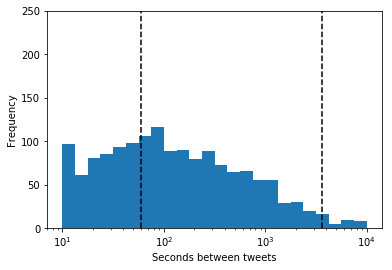

In [146]:
tweet_latencies = bot_timeline_df['timestamp'].sort_values().diff()/pd.Timedelta(1,'s')
ax = tweet_latencies.plot(kind='hist',bins=np.logspace(1,4,25))
ax.set_xscale('log')
ax.axvline(60,c='k',ls='--')
ax.axvline(3600,c='k',ls='--')
ax.set_ylim((0,250))
ax.set_xlabel('Seconds between tweets')

Given that all this account's tweets are retweets, what is the distribution of time from original tweet to its retweet? Mostly after an hour but within a day.

In [147]:
_s = (pd.to_datetime(bot_timeline_df['created']) - pd.to_datetime(bot_timeline_df['retweeted_created']))/pd.Timedelta(1,'s')
ax = _s.plot(kind='hist',bins=np.logspace(1,7,25))
ax.axvline(60,c='k',ls='--')
ax.axvline(3600,c='k',ls='--')
ax.axvline(86400,c='k',ls='--')
ax.set_xscale('log')
ax.set_xlabel('Seconds between tweets')


TypeError: <class 'bool'> is not convertible to datetime

I like to make a "temporal fingerprint" of a user account to see what days of the week and hours of the day a user is active. This user appears to be most active on Wednesday afternoons. But this appears to be much more random than I would expect (weekends *vs*. weekdays, nighttime *vs*. daytime, *etc*.).

Text(87.0, 0.5, '')

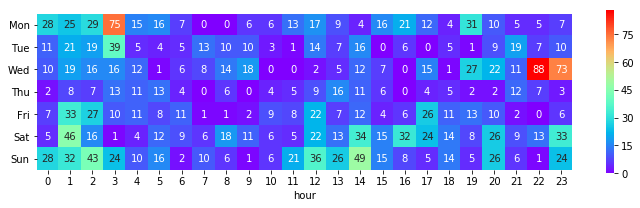

In [148]:
ct = pd.crosstab(bot_timeline_df['weekday'],bot_timeline_df['hour']).fillna(0)

f,ax = plt.subplots(1,1,figsize=(12,3))
sb.heatmap(ct,square=True,cmap='rainbow',ax=ax,annot=True,fmt='.0f')

ax.set_yticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],rotation=0)
ax.set_ylabel(None)

Distribution of sentiment scores.

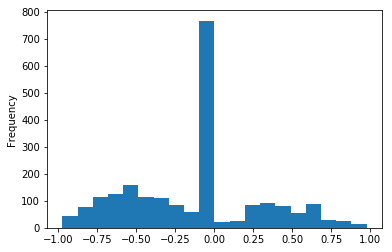

In [149]:
bot_timeline_df['sentiment'].plot(kind='hist',bins=20)

Sentiment scores over time.

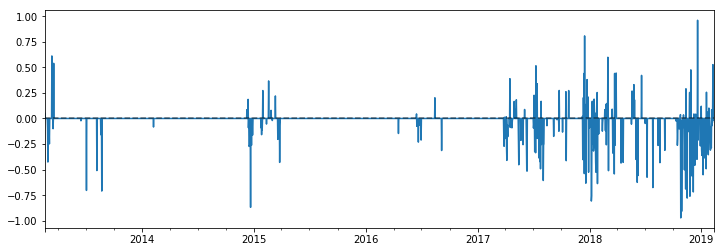

In [150]:
f,ax = plt.subplots(1,1,figsize=(12,4))
_s = bot_timeline_df.groupby('date').agg({'sentiment':'mean'})
_s = _s.reindex(pd.date_range(_s.index.min(),_s.index.max()),fill_value=0)
_s['sentiment'].plot(ax=ax)
ax.axhline(0,c='k',ls='--',alpha=.5)

## Get status replies

In [155]:
aoc_status = api.GetStatus(1095765485319319553)

In [156]:
vars(aoc_status)

{'param_defaults': {'contributors': None,
  'coordinates': None,
  'created_at': None,
  'current_user_retweet': None,
  'favorite_count': None,
  'favorited': None,
  'full_text': None,
  'geo': None,
  'hashtags': None,
  'id': None,
  'id_str': None,
  'in_reply_to_screen_name': None,
  'in_reply_to_status_id': None,
  'in_reply_to_user_id': None,
  'lang': None,
  'location': None,
  'media': None,
  'place': None,
  'possibly_sensitive': None,
  'quoted_status': None,
  'quoted_status_id': None,
  'quoted_status_id_str': None,
  'retweet_count': None,
  'retweeted': None,
  'retweeted_status': None,
  'scopes': None,
  'source': None,
  'text': None,
  'truncated': None,
  'urls': None,
  'user': None,
  'user_mentions': None,
  'withheld_copyright': None,
  'withheld_in_countries': None,
  'withheld_scope': None},
 'contributors': None,
 'coordinates': None,
 'created_at': 'Wed Feb 13 19:23:44 +0000 2019',
 'current_user_retweet': None,
 'favorite_count': 25284,
 'favorited': Fal

In [151]:
replies = api.GetReplies(count=20)

In [157]:
unquote('near%3A"Boulder%2C%20CO"%20within%3A15mi')

'near:"Boulder, CO" within:15mi'

In [159]:
quote('near:"Broomfield, CO" within:30mi')

'near%3A%22Broomfield%2C%20CO%22%20within%3A30mi'

In [168]:
api.GetSearch(term='#buildthewall beto',lang='en',result_type='popular')

[Status(ID=1095389042416500737, ScreenName=ACTforAmerica, Created=Tue Feb 12 18:27:53 +0000 2019, Text='Beto says walls are immoral yet he campaigns behind tall fencing. \n\nMakes you think!\n\n#BuildTheWall')]